In [317]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import warnings
from IPython.display import display, Latex
from torch import nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, auc
import missingno as msno
import catboost
from catboost import CatBoostClassifier
import optuna
from optuna.samplers import TPESampler
from catboost import Pool, cv
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)
sns.set()

In [421]:
pd.read_csv('C:/Users/danil/problem_test_labels')

,id,service_a,service_b,service_c,service_d,service_e,service_f,service_g,service_h,service_i,service_j,service_k,service_l,service_m,service_n
0,7957,0.990029,0.523233,0.177265,0.004413,0.038545,0.000763,0.007721,0.041867,0.002502,0.903715,0.876236,0.001076,0.000598,0.071929
1,693,0.032193,0.045904,0.033408,0.029817,0.059859,0.000300,0.008853,0.044510,0.002975,0.925548,0.870593,0.006297,0.002679,0.040297
2,15558,0.408600,0.606104,0.365534,0.005123,0.031174,0.000640,0.080661,0.192192,0.009943,0.817613,0.754604,0.003866,0.002486,0.220461
3,15614,0.281188,0.235097,0.304112,0.004863,0.019739,0.000745,0.108933,0.453033,0.017703,0.833581,0.725728,0.242417,0.200014,0.213523
4,8149,0.949841,0.614540,0.433542,0.001954,0.013710,0.000690,0.129630,0.186452,0.014187,0.696876,0.564802,0.022869,0.001811,0.011374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,200,0.104832,0.122458,0.110740,0.005643,0.101266,0.125039,0.077932,0.178186,0.006862,0.916689,0.793921,0.055763,0.018885,0.015421
1996,10876,0.911218,0.535751,0.427764,0.005307,0.007206,0.120541,0.077046,0.218115,0.010453,0.831681,0.812220,0.007662,0.000448,0.126243
1997,4035,0.264790,0.192035,0.334090,0.005542,0.017815,0.000812,0.047596,0.241552,0.017869,0.913382,0.763582,0.007854,0.000452,0.292266
1998,3640,0.173144,0.177271,0.247949,0.003344,0.018785,0.000313,0.039070,0.260167,0.015651,0.931502,0.811456,0.033393,0.000897,0.011623


In [ ]:
# План

# 0) Exploration data analysis, изучение распределений датасетов, сбалансированность выборки и общая информция
# 1) Исследование природы прощуенных данных, библиотека missingno, методы заполнения
# 2) Подготовка датасета для обучения
# 3) Обзор возможных алгоритмов, создание baseline модели, тестирование и кросс-валидация
# 4) Обучение модели
# 5) Валидация
# 6) Подготовка тестового датасета
# 7) Предикт, постпредикт-анализ

# 0) EDA


In [3]:
#Загружаем данные, смотрим на общую информацию
train_table=pd.read_csv('C:/Users/danil/problem_train.csv')
test_table=pd.read_csv('C:/Users/danil/problem_test.csv')
train_labels=pd.read_csv('C:/Users/danil/problem_labels.csv')
train_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Columns: 1379 entries, id to c_1377
dtypes: float64(345), int64(9), object(1025)
memory usage: 84.2+ MB


In [4]:
train_labels

,id,service_a,service_b,service_c,service_d,service_e,service_f,service_g,service_h,service_i,service_j,service_k,service_l,service_m,service_n
0,11193,1,1,0,0,0,0,0,0,0,1,1,0,0,0
1,11382,0,0,0,0,0,0,0,0,0,1,1,0,0,0
2,16531,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3,1896,0,0,0,1,0,0,0,0,0,1,0,1,0,0
4,18262,0,0,0,1,1,0,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,10898,1,1,1,0,0,0,1,0,0,1,1,1,1,1
7996,16664,0,0,0,0,0,0,0,0,0,1,1,0,0,0
7997,5334,1,0,0,0,0,0,0,0,0,1,1,0,0,0
7998,7905,1,1,1,0,0,0,0,0,0,1,1,0,0,0


In [5]:
#Посмотрим, насколько сбалансированы классы (соотношение 0/1)
ratio_list=[train_labels[name].value_counts().values for name in train_labels.columns]
ratio_list=[ratio_list[i][0]/ratio_list[i][1] for i in range(len(ratio_list))]

ratio_list=pd.concat([pd.DataFrame(train_labels.columns.values[1:]), pd.DataFrame(ratio_list[1:])],
                       axis=1)

ratio_list.columns=['column', 'ratio value 0/1']
ratio_list
#Видим, что выборка преимущественно несбалансирована

,column,ratio value 0/1
0,service_a,1.118083
1,service_b,2.046458
2,service_c,2.822265
3,service_d,57.823529
4,service_e,17.561485
5,service_f,33.334764
6,service_g,18.277108
7,service_h,2.367003
8,service_i,61.015504
9,service_j,5.589786


In [6]:
#рассмотрим отдельно фичи без NaN-values
not_na_names=[name for name in train_table.columns if train_table[name].isna().sum()==0]
filled_columns=train_table[not_na_names]
filled_columns=filled_columns.drop(['id', 'release'], axis=1)
filled_columns


,n_0047,n_0050,n_0052,n_0061,n_0067,n_0075,n_0078,n_0091,n_0108,n_0109,...,c_0870,c_0980,c_1145,c_1158,c_1189,c_1223,c_1227,c_1244,c_1259,c_1348
0,1,1,1,1,0.928571,1,0.800000,1,0.800000,0.1875,...,b,c,b,g,b,c,a,d,n,b
1,1,1,1,1,0.928571,1,0.666667,1,0.666667,0.1875,...,b,c,b,g,b,a,a,d,e,b
2,1,1,1,1,0.428571,1,0.833333,1,0.833333,0.1875,...,b,c,b,j,b,c,a,d,w,b
3,1,1,1,1,0.571429,1,0.566667,1,0.566667,0.1875,...,b,c,b,e,b,c,a,d,e,b
4,1,1,1,1,0.928571,1,0.600000,1,0.600000,0.2500,...,a,c,c,b,b,c,a,d,e,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,1,1,1,1,0.000000,1,0.166667,1,0.166667,0.0625,...,b,a,b,b,a,c,b,a,i,c
7996,1,1,1,1,0.714286,1,0.733333,1,0.733333,0.1250,...,a,c,c,c,b,c,a,d,w,b
7997,1,1,1,1,1.000000,1,0.833333,1,0.833333,0.0625,...,b,a,b,d,b,c,a,d,n,b
7998,1,1,1,1,0.357143,1,0.400000,1,0.400000,0.1250,...,a,b,c,i,b,c,a,a,n,b


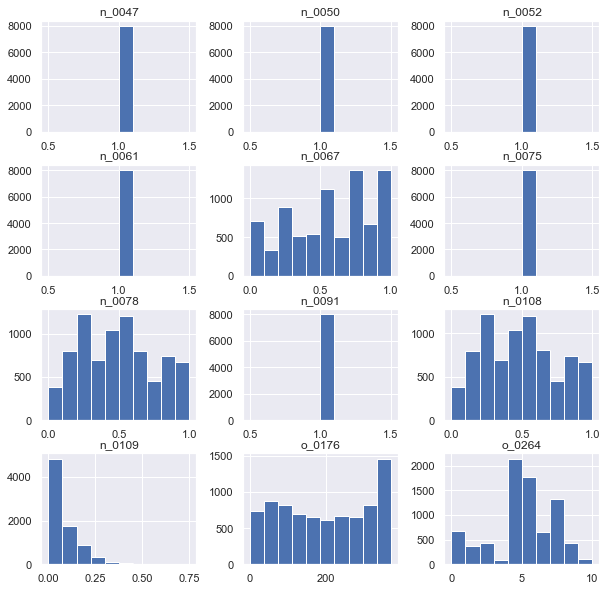

In [7]:
#Посмотрим на распределения фич без NaN-ов. Если корреляционная матрица даст какую-то устойчивую связь 
#между признаками, то это позволит сузить спектр выбора парадигмы заполненения NaN'ов
filled_columns.hist(figsize=(10,10))
plt.show()

In [8]:
info=pd.DataFrame()
info['mean']=filled_columns.mean()
info['variance']=filled_columns.var()
info

,mean,variance
n_0047,1.000000,0.000000
n_0050,1.000000,0.000000
n_0052,1.000000,0.000000
n_0061,1.000000,0.000000
n_0067,0.562482,0.085787
n_0075,1.000000,0.000000
n_0078,0.487271,0.068476
n_0091,1.000000,0.000000
n_0108,0.487258,0.068472
n_0109,0.080375,0.007215


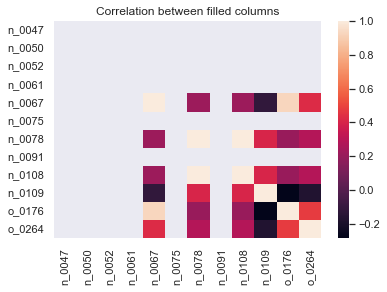

<IPython.core.display.Latex object>

In [77]:
plt.title('Correlation between filled columns')
sns.heatmap(filled_columns.corr())
plt.show()

text='Из корреляционной heatmap можем заключить, что средний уровень корреляции между признаками не позволяет использовать какую-либо информативную статистику о выборке'
display(Latex(text))

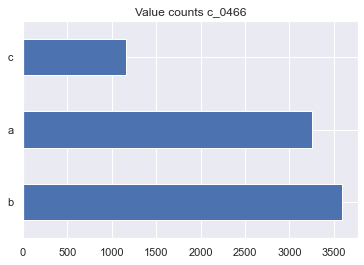

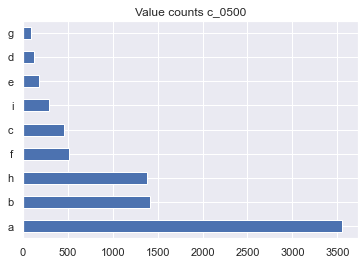

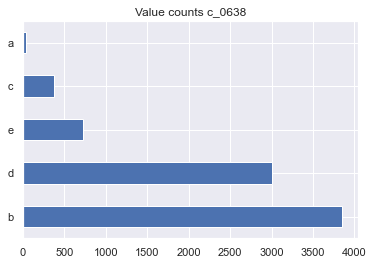

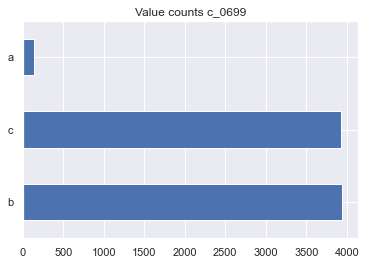

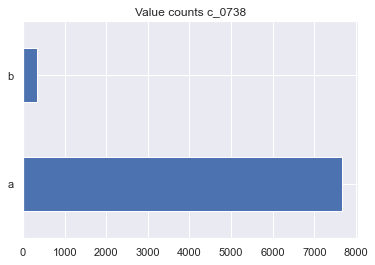

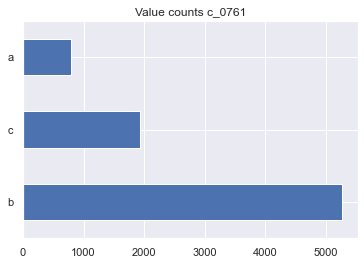

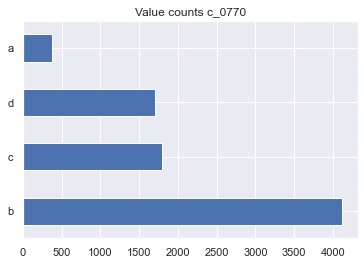

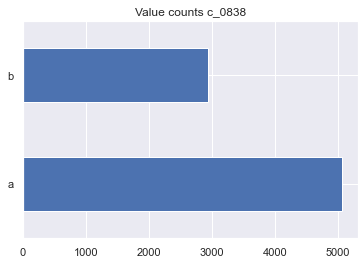

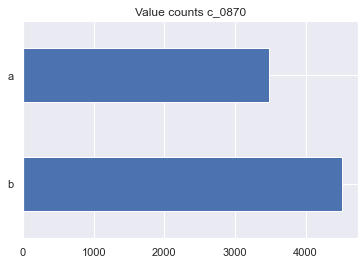

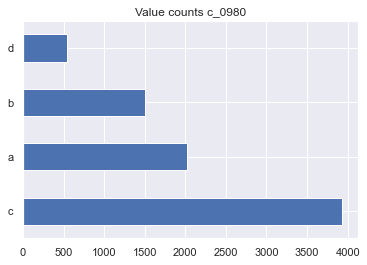

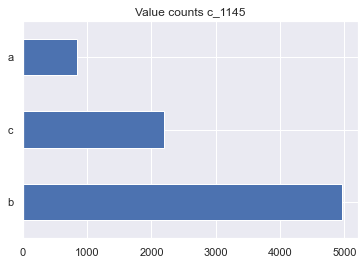

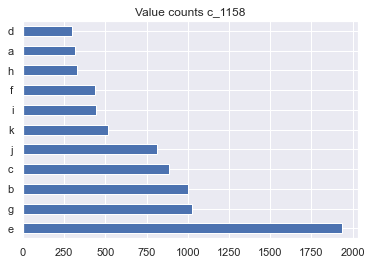

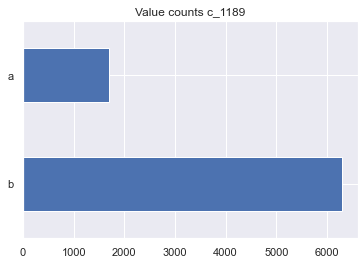

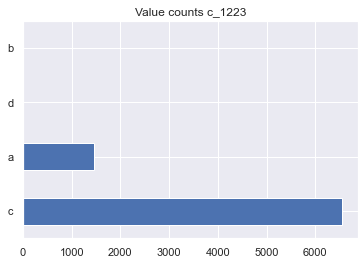

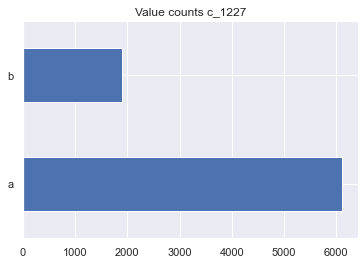

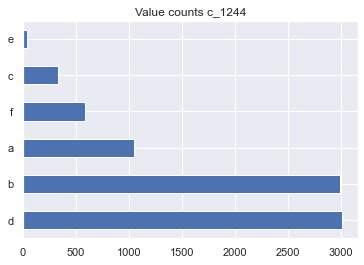

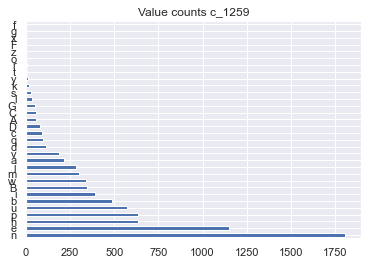

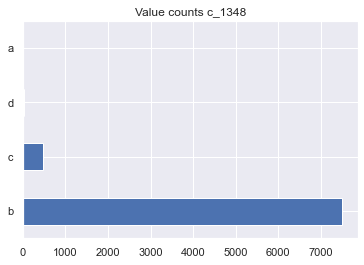

In [10]:
object_names=[name for name in filled_columns.columns[2:] if filled_columns[name].values.dtype==object]
for name in object_names:
    plt.title('Value counts ' + name)
    filled_columns[name].value_counts().plot(kind='barh')
    plt.show()

In [89]:
#Смотрим на проценты NaN-ов для каждой фичи. Очевидно, что если количество NaN-ов больше некоторого 
#трешхолда, то информативность признака под большим вопросом
nan_table=train_table.drop(not_na_names, axis=1)

print(f'Средний процент пропущенных значений {nan_table.isna().sum().mean()/len(nan_table)*100}')
nan_table.isna().sum()/len(nan_table)*100


Средний процент пропущенных значений 84.62249443207128


n_0000    99.8500
n_0001    95.1500
n_0002     4.2250
n_0003    98.6000
n_0004    99.2750
           ...   
c_1373    94.5000
c_1374    60.5625
c_1375    92.9625
c_1376    99.9125
c_1377    76.1500
Length: 1347, dtype: float64

In [12]:
#общая информация про отсутствующие значения
nan_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Columns: 1347 entries, n_0000 to c_1377
dtypes: float64(341), object(1006)
memory usage: 82.2+ MB


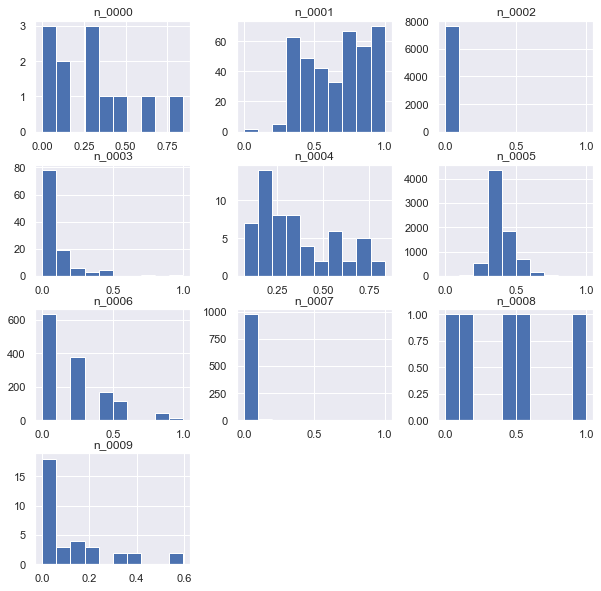

In [13]:
nan_table[nan_table.columns[:10]].hist(figsize=(10,10))
plt.show()

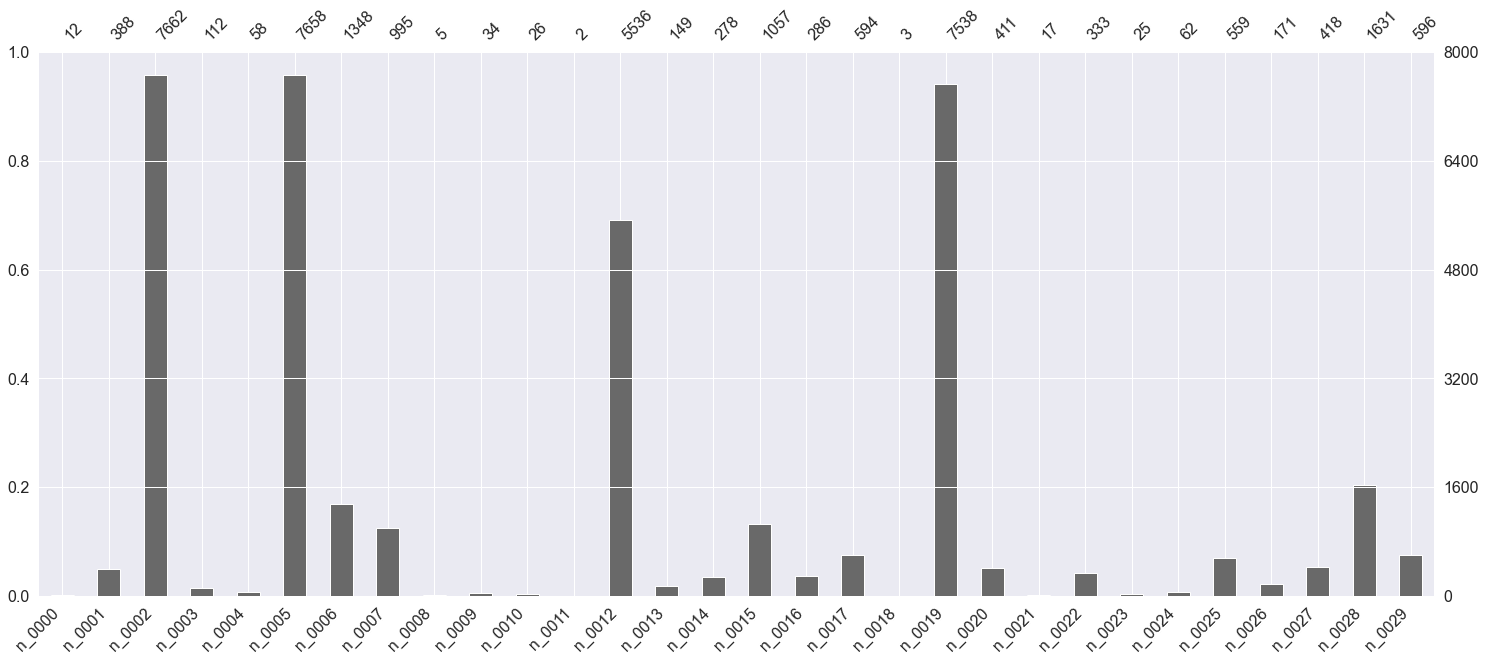

In [14]:
msno.bar(nan_table[nan_table.columns[:30:]])
plt.show()

In [15]:
nan_table.corr()

,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,n_0008,n_0009,...,c_1072,c_1129,c_1148,c_1168,c_1230,c_1257,c_1277,c_1281,c_1308,c_1332
n_0000,1.000000,NaN,-0.476711,NaN,NaN,-0.171652,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n_0001,NaN,1.000000,-0.678553,0.348201,NaN,0.193211,-0.023437,-0.005568,NaN,0.002239,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n_0002,-0.476711,-0.678553,1.000000,-0.420242,-0.683816,0.154610,0.010384,-0.042976,0.275037,-0.334739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n_0003,NaN,0.348201,-0.420242,1.000000,NaN,-0.061605,-0.130479,-0.442624,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n_0004,NaN,NaN,-0.683816,NaN,1.000000,0.354162,0.686580,-0.668687,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c_1257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c_1277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c_1281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c_1308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


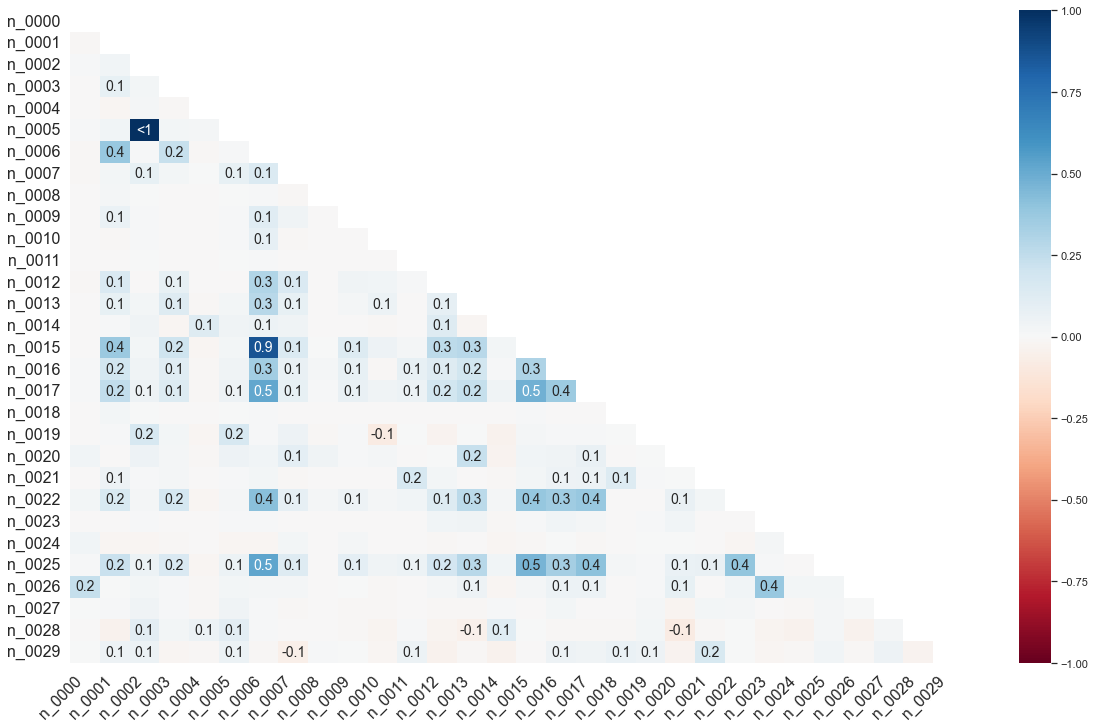

<IPython.core.display.Latex object>

In [78]:
msno.heatmap(nan_table[nan_table.columns[:30:]])
plt.show()

text='Из графика можем заметить, что средний уровень корреляции порядка 0.1, что не позволяет нам сходу выдвинуть какую-либо гипотезу о том, каким конкретно образом заполнять пропуски'
display(Latex(text))

# Заполнение NaN-values

In [17]:
#С пропущенными значениями можем делать следующее
#0) Заполнение некоторой статистикой (средним, etc.) из выборки 
#1) дефолтные импьюторы/библиотечные методы
#2) Регрессия/выбор значения из ближайших заполненных экземпляров с заполненным значением
#3) Интерполяция
# Для Столбцов с адекватным процентов NaN'values интерполяция - оптимальная стратегия
# т.к. не требует ресурсов для обучения

#Средний процент недостающих данных - 84, что чрезмерно много и ставит под сомнение
#информативность этих признаков

#Положим гипотезу об информативности интерполированных данных с <50% и выясним, сколько признаков 
#попадает в "серую зону" 50-75%
print(f'50% - 75%:')
len([name for name in nan_table.isna().sum().index if 
 nan_table[name].isna().sum()/len(nan_table)*100>50 and nan_table[name].isna().sum()/len(nan_table)*100<75])

50% - 75%:


53

In [172]:
#Будем искать подходящие фичи, подбирая трешхолд количества NaN-values и заполнять их
def get_tuned_data_train(percent):
    valid_names=[name for name in nan_table.isna().sum().index if nan_table[name].isna().sum()/len(nan_table)*100<percent]
    nan_table_upd=nan_table[valid_names].interpolate()
    
    for name in nan_table_upd.columns:
        if nan_table_upd[name].isna().sum()!=0:
            nan_table_upd[name]=nan_table_upd[name].fillna(value=nan_table_upd[name].mode()[0])
    
    train_merged = pd.concat([filled_columns, nan_table_upd, train_table['id'], train_table['release']], axis=1)
    cat_features=list(train_merged.columns[np.where(train_merged.dtypes == object)].values)
    
    return train_merged, cat_features
    
text='Средний процент пропущенных значений порядка 84, что фактически нивелирует информативность этих признаков. Закономерно воспользоваться теми признаками, объем пропусков в которых не превосходит некоторого значения (подбираем либо эмпирически, либо с помощью какого-то итерационного метода из некоторого интервала). Далее используем интерполяцию (метод экономит время, т.к. не надо обучать) + некоторой статистикой (i.e. средним) заполняем оставшиеся значения'
text=text+'. Всё это отдельно обернем в функции для тестового и тренировочного датасетов'
display(Latex(text))

<IPython.core.display.Latex object>

In [259]:
train_merged, cat_features = get_tuned_data_train(50)
stable_columns_names=[name for name in train_merged.columns if train_merged[name].value_counts().values[0]==8000]
train_merged=train_merged.drop(stable_columns_names, axis=1)
cat_features=[name for name in train_merged.columns if train_merged[name].dtype==object]

In [250]:
data_train, data_test, target_train, target_test = train_test_split(train_merged, train_labels['service_e'], shuffle=True)

# Выбор модели и метрик

In [178]:

text='На табулярных данных логично использовать классические ml лгоритмы-классификаторы. Линейные модели не подходят в силу специфики датасета.В силу высокого количества категориальных признаков логично использовать CatBoost с Logloss в качестве лосс-функции'

display(Latex(text))
display(Latex(f'Возможная альтернатива - энкодер, латентное пространство которого дискретно и является просто решеткой в $Z_{2}$'))
display(Latex('Также возможная альтернатива - нейронная SOTA-модель TabNet'))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [179]:
text='Мы хотим установить релевантность модели по метрике Logloss, которая посовместительству является лосс-функцией для нашей модели. Однако для устойчивости модели рационально добавить аналоговую метрику. Так как выборка сильно несбалансированна, нужно что-то устойчивое к дисбалансу классов. Критерий AUC-ROC устойчив к несбалансированным классам, поэтому будем валидировать модель на этой метрике'
display(Latex(text))

<IPython.core.display.Latex object>

In [ ]:
#Model baseline

In [251]:
params={'iterations': 1000,
'early_stopping_rounds' : 50}

model=CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', **params)
model.fit(data_train, target_train, cat_features=cat_features, verbose=False, plot=True, eval_set=(data_test, target_test.values),early_stopping_rounds=50)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [223]:
roc_auc_score(target_test, model.predict_proba(data_test)[:,1])

0.8292639690509335

# Подбор параметров

In [26]:
##Тюнинг параметров
#Возможные методы: GridSearch, hyperopt, etc.  + Optuna
display(Latex(f'Будем настраивать основные параметры - скорость обучения, регуляризация, бутстрапирование'))

<IPython.core.display.Latex object>

In [341]:
#Утилитная функция обучения модели на сетке параметров
def objective(trial):
    
    data_train, data_test, target_train, target_test=train_test_split(train_merged, 
                                                                      train_labels['service_j'], shuffle=True)
    
    params={
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
    }
    
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    
    
    model = catboost.CatBoostClassifier(**params)
    model.fit(data_train, target_train, cat_features=cat_features)
    prediction = model.predict_proba(data_test)
    return log_loss(target_test, prediction)

In [342]:
#Ищем оптимум
def find_optimize(seed):
    sampler = TPESampler(seed=1)
    study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=10)
    
    trial = study.best_trial
    
    return trial.params

In [343]:
pars=find_optimize(1)

Learning rate set to 0.022141
0:	learn: 0.6770991	total: 120ms	remaining: 1m 59s
1:	learn: 0.6630586	total: 291ms	remaining: 2m 24s
2:	learn: 0.6491902	total: 511ms	remaining: 2m 49s
3:	learn: 0.6357258	total: 706ms	remaining: 2m 55s
4:	learn: 0.6232258	total: 861ms	remaining: 2m 51s
5:	learn: 0.6110554	total: 1.02s	remaining: 2m 48s
6:	learn: 0.6015862	total: 1.04s	remaining: 2m 28s
7:	learn: 0.5903105	total: 1.28s	remaining: 2m 38s
8:	learn: 0.5817168	total: 1.33s	remaining: 2m 26s
9:	learn: 0.5726331	total: 1.39s	remaining: 2m 17s
10:	learn: 0.5628508	total: 1.52s	remaining: 2m 16s
11:	learn: 0.5549414	total: 1.59s	remaining: 2m 10s
12:	learn: 0.5456556	total: 1.83s	remaining: 2m 18s
13:	learn: 0.5378686	total: 1.95s	remaining: 2m 17s
14:	learn: 0.5295669	total: 2.17s	remaining: 2m 22s
15:	learn: 0.5216073	total: 2.54s	remaining: 2m 36s
16:	learn: 0.5140671	total: 2.73s	remaining: 2m 37s
17:	learn: 0.5069227	total: 2.91s	remaining: 2m 38s
18:	learn: 0.5002177	total: 3.07s	remaining:

157:	learn: 0.3193865	total: 37s	remaining: 3m 17s
158:	learn: 0.3189013	total: 37.5s	remaining: 3m 18s
159:	learn: 0.3183553	total: 38s	remaining: 3m 19s
160:	learn: 0.3179507	total: 39.1s	remaining: 3m 23s
161:	learn: 0.3175998	total: 40.6s	remaining: 3m 30s
162:	learn: 0.3173309	total: 41.9s	remaining: 3m 35s
163:	learn: 0.3164019	total: 42.7s	remaining: 3m 37s
164:	learn: 0.3160688	total: 43.9s	remaining: 3m 42s
165:	learn: 0.3157594	total: 45.4s	remaining: 3m 48s
166:	learn: 0.3155556	total: 46.1s	remaining: 3m 49s
167:	learn: 0.3151775	total: 47s	remaining: 3m 52s
168:	learn: 0.3144349	total: 47.9s	remaining: 3m 55s
169:	learn: 0.3139282	total: 48.9s	remaining: 3m 58s
170:	learn: 0.3132448	total: 49.9s	remaining: 4m 1s
171:	learn: 0.3132023	total: 50.1s	remaining: 4m 1s
172:	learn: 0.3131215	total: 50.5s	remaining: 4m 1s
173:	learn: 0.3126563	total: 51.3s	remaining: 4m 3s
174:	learn: 0.3125169	total: 52.5s	remaining: 4m 7s
175:	learn: 0.3120415	total: 53.2s	remaining: 4m 8s
176:	

311:	learn: 0.2666282	total: 1m 41s	remaining: 3m 44s
312:	learn: 0.2663242	total: 1m 41s	remaining: 3m 43s
313:	learn: 0.2660011	total: 1m 42s	remaining: 3m 42s
314:	learn: 0.2656083	total: 1m 42s	remaining: 3m 42s
315:	learn: 0.2651472	total: 1m 42s	remaining: 3m 41s
316:	learn: 0.2651224	total: 1m 42s	remaining: 3m 40s
317:	learn: 0.2648024	total: 1m 42s	remaining: 3m 40s
318:	learn: 0.2644930	total: 1m 42s	remaining: 3m 39s
319:	learn: 0.2643389	total: 1m 42s	remaining: 3m 38s
320:	learn: 0.2641078	total: 1m 43s	remaining: 3m 38s
321:	learn: 0.2635340	total: 1m 43s	remaining: 3m 37s
322:	learn: 0.2635234	total: 1m 43s	remaining: 3m 36s
323:	learn: 0.2632129	total: 1m 43s	remaining: 3m 36s
324:	learn: 0.2629665	total: 1m 43s	remaining: 3m 35s
325:	learn: 0.2626298	total: 1m 43s	remaining: 3m 34s
326:	learn: 0.2622561	total: 1m 44s	remaining: 3m 34s
327:	learn: 0.2616981	total: 1m 44s	remaining: 3m 33s
328:	learn: 0.2612597	total: 1m 44s	remaining: 3m 33s
329:	learn: 0.2609516	total:

465:	learn: 0.2153837	total: 2m 15s	remaining: 2m 34s
466:	learn: 0.2152019	total: 2m 15s	remaining: 2m 34s
467:	learn: 0.2150074	total: 2m 15s	remaining: 2m 33s
468:	learn: 0.2144945	total: 2m 15s	remaining: 2m 33s
469:	learn: 0.2141587	total: 2m 15s	remaining: 2m 33s
470:	learn: 0.2140577	total: 2m 16s	remaining: 2m 32s
471:	learn: 0.2136687	total: 2m 16s	remaining: 2m 32s
472:	learn: 0.2133321	total: 2m 16s	remaining: 2m 31s
473:	learn: 0.2129001	total: 2m 16s	remaining: 2m 31s
474:	learn: 0.2125494	total: 2m 16s	remaining: 2m 31s
475:	learn: 0.2120358	total: 2m 17s	remaining: 2m 31s
476:	learn: 0.2118082	total: 2m 17s	remaining: 2m 30s
477:	learn: 0.2116721	total: 2m 18s	remaining: 2m 30s
478:	learn: 0.2111402	total: 2m 18s	remaining: 2m 30s
479:	learn: 0.2107315	total: 2m 18s	remaining: 2m 30s
480:	learn: 0.2104771	total: 2m 19s	remaining: 2m 29s
481:	learn: 0.2101516	total: 2m 19s	remaining: 2m 29s
482:	learn: 0.2100513	total: 2m 19s	remaining: 2m 29s
483:	learn: 0.2099431	total:

618:	learn: 0.1744107	total: 2m 58s	remaining: 1m 49s
619:	learn: 0.1741533	total: 2m 58s	remaining: 1m 49s
620:	learn: 0.1738198	total: 2m 58s	remaining: 1m 49s
621:	learn: 0.1735360	total: 2m 58s	remaining: 1m 48s
622:	learn: 0.1733627	total: 2m 59s	remaining: 1m 48s
623:	learn: 0.1730721	total: 2m 59s	remaining: 1m 48s
624:	learn: 0.1728649	total: 2m 59s	remaining: 1m 47s
625:	learn: 0.1727654	total: 2m 59s	remaining: 1m 47s
626:	learn: 0.1726843	total: 3m	remaining: 1m 47s
627:	learn: 0.1726457	total: 3m	remaining: 1m 46s
628:	learn: 0.1723987	total: 3m	remaining: 1m 46s
629:	learn: 0.1720497	total: 3m	remaining: 1m 46s
630:	learn: 0.1720163	total: 3m	remaining: 1m 45s
631:	learn: 0.1719895	total: 3m 1s	remaining: 1m 45s
632:	learn: 0.1715295	total: 3m 1s	remaining: 1m 45s
633:	learn: 0.1711614	total: 3m 1s	remaining: 1m 44s
634:	learn: 0.1709771	total: 3m 1s	remaining: 1m 44s
635:	learn: 0.1707053	total: 3m 1s	remaining: 1m 44s
636:	learn: 0.1703957	total: 3m 2s	remaining: 1m 43s


773:	learn: 0.1396957	total: 3m 28s	remaining: 1m
774:	learn: 0.1396249	total: 3m 28s	remaining: 1m
775:	learn: 0.1394493	total: 3m 28s	remaining: 1m
776:	learn: 0.1391336	total: 3m 28s	remaining: 59.9s
777:	learn: 0.1388756	total: 3m 28s	remaining: 59.6s
778:	learn: 0.1388188	total: 3m 29s	remaining: 59.3s
779:	learn: 0.1384667	total: 3m 29s	remaining: 59s
780:	learn: 0.1382766	total: 3m 29s	remaining: 58.7s
781:	learn: 0.1380515	total: 3m 29s	remaining: 58.4s
782:	learn: 0.1379952	total: 3m 29s	remaining: 58.1s
783:	learn: 0.1379370	total: 3m 29s	remaining: 57.9s
784:	learn: 0.1377892	total: 3m 30s	remaining: 57.6s
785:	learn: 0.1376190	total: 3m 30s	remaining: 57.3s
786:	learn: 0.1374755	total: 3m 30s	remaining: 57s
787:	learn: 0.1372829	total: 3m 30s	remaining: 56.7s
788:	learn: 0.1372537	total: 3m 30s	remaining: 56.4s
789:	learn: 0.1372224	total: 3m 31s	remaining: 56.1s
790:	learn: 0.1370396	total: 3m 31s	remaining: 55.8s
791:	learn: 0.1370095	total: 3m 31s	remaining: 55.6s
792:	l

930:	learn: 0.1156633	total: 3m 57s	remaining: 17.6s
931:	learn: 0.1154531	total: 3m 57s	remaining: 17.4s
932:	learn: 0.1153265	total: 3m 58s	remaining: 17.1s
933:	learn: 0.1151851	total: 3m 58s	remaining: 16.8s
934:	learn: 0.1149631	total: 3m 58s	remaining: 16.6s
935:	learn: 0.1148520	total: 3m 58s	remaining: 16.3s
936:	learn: 0.1146287	total: 3m 58s	remaining: 16.1s
937:	learn: 0.1145275	total: 3m 58s	remaining: 15.8s
938:	learn: 0.1144698	total: 3m 59s	remaining: 15.5s
939:	learn: 0.1142984	total: 3m 59s	remaining: 15.3s
940:	learn: 0.1142077	total: 3m 59s	remaining: 15s
941:	learn: 0.1141357	total: 3m 59s	remaining: 14.8s
942:	learn: 0.1139915	total: 3m 59s	remaining: 14.5s
943:	learn: 0.1137251	total: 4m	remaining: 14.2s
944:	learn: 0.1135964	total: 4m	remaining: 14s
945:	learn: 0.1135692	total: 4m	remaining: 13.7s
946:	learn: 0.1132814	total: 4m	remaining: 13.5s
947:	learn: 0.1132626	total: 4m	remaining: 13.2s
948:	learn: 0.1131189	total: 4m 1s	remaining: 13s
949:	learn: 0.112876

92:	learn: 0.3792047	total: 8.51s	remaining: 1m 23s
93:	learn: 0.3788501	total: 8.61s	remaining: 1m 22s
94:	learn: 0.3784417	total: 8.65s	remaining: 1m 22s
95:	learn: 0.3779410	total: 8.71s	remaining: 1m 22s
96:	learn: 0.3774442	total: 8.83s	remaining: 1m 22s
97:	learn: 0.3768281	total: 8.92s	remaining: 1m 22s
98:	learn: 0.3763945	total: 9.01s	remaining: 1m 22s
99:	learn: 0.3761172	total: 9.1s	remaining: 1m 21s
100:	learn: 0.3757766	total: 9.19s	remaining: 1m 21s
101:	learn: 0.3753139	total: 9.3s	remaining: 1m 21s
102:	learn: 0.3751109	total: 9.35s	remaining: 1m 21s
103:	learn: 0.3749424	total: 9.41s	remaining: 1m 21s
104:	learn: 0.3747831	total: 9.46s	remaining: 1m 20s
105:	learn: 0.3746412	total: 9.52s	remaining: 1m 20s
106:	learn: 0.3743828	total: 9.62s	remaining: 1m 20s
107:	learn: 0.3740979	total: 9.74s	remaining: 1m 20s
108:	learn: 0.3737794	total: 9.86s	remaining: 1m 20s
109:	learn: 0.3735319	total: 9.92s	remaining: 1m 20s
110:	learn: 0.3731228	total: 10s	remaining: 1m 20s
111:	

250:	learn: 0.3566712	total: 24.4s	remaining: 1m 12s
251:	learn: 0.3566129	total: 24.5s	remaining: 1m 12s
252:	learn: 0.3565121	total: 24.6s	remaining: 1m 12s
253:	learn: 0.3564654	total: 24.7s	remaining: 1m 12s
254:	learn: 0.3564288	total: 24.8s	remaining: 1m 12s
255:	learn: 0.3563230	total: 24.8s	remaining: 1m 12s
256:	learn: 0.3562991	total: 24.9s	remaining: 1m 12s
257:	learn: 0.3562486	total: 25.1s	remaining: 1m 12s
258:	learn: 0.3560912	total: 25.2s	remaining: 1m 12s
259:	learn: 0.3560128	total: 25.3s	remaining: 1m 12s
260:	learn: 0.3559853	total: 25.4s	remaining: 1m 11s
261:	learn: 0.3559853	total: 25.4s	remaining: 1m 11s
262:	learn: 0.3559467	total: 25.5s	remaining: 1m 11s
263:	learn: 0.3558654	total: 25.6s	remaining: 1m 11s
264:	learn: 0.3558154	total: 25.7s	remaining: 1m 11s
265:	learn: 0.3557942	total: 25.8s	remaining: 1m 11s
266:	learn: 0.3557153	total: 25.9s	remaining: 1m 11s
267:	learn: 0.3555993	total: 26s	remaining: 1m 11s
268:	learn: 0.3555993	total: 26.1s	remaining: 1m

409:	learn: 0.3482871	total: 38.4s	remaining: 55.3s
410:	learn: 0.3482729	total: 38.5s	remaining: 55.2s
411:	learn: 0.3482729	total: 38.6s	remaining: 55s
412:	learn: 0.3481507	total: 38.7s	remaining: 54.9s
413:	learn: 0.3481507	total: 38.7s	remaining: 54.8s
414:	learn: 0.3481156	total: 38.7s	remaining: 54.6s
415:	learn: 0.3481156	total: 38.8s	remaining: 54.4s
416:	learn: 0.3480296	total: 38.9s	remaining: 54.3s
417:	learn: 0.3480296	total: 38.9s	remaining: 54.1s
418:	learn: 0.3479771	total: 39s	remaining: 54.1s
419:	learn: 0.3478705	total: 39.1s	remaining: 54s
420:	learn: 0.3478344	total: 39.2s	remaining: 54s
421:	learn: 0.3478300	total: 39.3s	remaining: 53.8s
422:	learn: 0.3478294	total: 39.3s	remaining: 53.6s
423:	learn: 0.3477691	total: 39.4s	remaining: 53.6s
424:	learn: 0.3477509	total: 39.5s	remaining: 53.5s
425:	learn: 0.3475834	total: 39.7s	remaining: 53.4s
426:	learn: 0.3474750	total: 39.8s	remaining: 53.4s
427:	learn: 0.3473185	total: 39.9s	remaining: 53.3s
428:	learn: 0.347310

570:	learn: 0.3348619	total: 55.6s	remaining: 41.8s
571:	learn: 0.3348026	total: 55.7s	remaining: 41.7s
572:	learn: 0.3347299	total: 55.8s	remaining: 41.6s
573:	learn: 0.3346536	total: 55.9s	remaining: 41.5s
574:	learn: 0.3345787	total: 56s	remaining: 41.4s
575:	learn: 0.3345144	total: 56.1s	remaining: 41.3s
576:	learn: 0.3344063	total: 56.2s	remaining: 41.2s
577:	learn: 0.3342358	total: 56.3s	remaining: 41.1s
578:	learn: 0.3341877	total: 56.4s	remaining: 41s
579:	learn: 0.3341253	total: 56.7s	remaining: 41s
580:	learn: 0.3340718	total: 57s	remaining: 41.1s
581:	learn: 0.3340196	total: 57.2s	remaining: 41.1s
582:	learn: 0.3340036	total: 57.3s	remaining: 41s
583:	learn: 0.3339543	total: 57.4s	remaining: 40.9s
584:	learn: 0.3339400	total: 57.5s	remaining: 40.8s
585:	learn: 0.3338328	total: 57.6s	remaining: 40.7s
586:	learn: 0.3337300	total: 57.7s	remaining: 40.6s
587:	learn: 0.3336806	total: 57.8s	remaining: 40.5s
588:	learn: 0.3336305	total: 57.9s	remaining: 40.4s
589:	learn: 0.3335906	

729:	learn: 0.3218102	total: 1m 12s	remaining: 26.8s
730:	learn: 0.3216840	total: 1m 12s	remaining: 26.7s
731:	learn: 0.3216225	total: 1m 12s	remaining: 26.6s
732:	learn: 0.3215251	total: 1m 12s	remaining: 26.5s
733:	learn: 0.3213202	total: 1m 12s	remaining: 26.4s
734:	learn: 0.3212653	total: 1m 13s	remaining: 26.3s
735:	learn: 0.3211880	total: 1m 13s	remaining: 26.3s
736:	learn: 0.3210268	total: 1m 13s	remaining: 26.3s
737:	learn: 0.3209821	total: 1m 13s	remaining: 26.2s
738:	learn: 0.3209104	total: 1m 13s	remaining: 26.1s
739:	learn: 0.3208802	total: 1m 13s	remaining: 26s
740:	learn: 0.3207691	total: 1m 14s	remaining: 25.9s
741:	learn: 0.3207225	total: 1m 14s	remaining: 25.8s
742:	learn: 0.3206928	total: 1m 14s	remaining: 25.7s
743:	learn: 0.3206018	total: 1m 14s	remaining: 25.6s
744:	learn: 0.3204841	total: 1m 14s	remaining: 25.5s
745:	learn: 0.3204372	total: 1m 14s	remaining: 25.4s
746:	learn: 0.3203376	total: 1m 14s	remaining: 25.3s
747:	learn: 0.3202949	total: 1m 14s	remaining: 2

886:	learn: 0.3099901	total: 1m 28s	remaining: 11.3s
887:	learn: 0.3099173	total: 1m 28s	remaining: 11.2s
888:	learn: 0.3099082	total: 1m 29s	remaining: 11.1s
889:	learn: 0.3098886	total: 1m 29s	remaining: 11s
890:	learn: 0.3098193	total: 1m 29s	remaining: 10.9s
891:	learn: 0.3097272	total: 1m 29s	remaining: 10.8s
892:	learn: 0.3096982	total: 1m 29s	remaining: 10.7s
893:	learn: 0.3095721	total: 1m 29s	remaining: 10.6s
894:	learn: 0.3095535	total: 1m 29s	remaining: 10.5s
895:	learn: 0.3095334	total: 1m 29s	remaining: 10.4s
896:	learn: 0.3094591	total: 1m 29s	remaining: 10.3s
897:	learn: 0.3093920	total: 1m 30s	remaining: 10.2s
898:	learn: 0.3093606	total: 1m 30s	remaining: 10.1s
899:	learn: 0.3092760	total: 1m 30s	remaining: 10s
900:	learn: 0.3092467	total: 1m 30s	remaining: 9.94s
901:	learn: 0.3091927	total: 1m 30s	remaining: 9.86s
902:	learn: 0.3090744	total: 1m 30s	remaining: 9.76s
903:	learn: 0.3089924	total: 1m 31s	remaining: 9.68s
904:	learn: 0.3089370	total: 1m 31s	remaining: 9.6

43:	learn: 0.4189072	total: 1.89s	remaining: 41s
44:	learn: 0.4176123	total: 1.9s	remaining: 40.3s
45:	learn: 0.4162699	total: 1.91s	remaining: 39.6s
46:	learn: 0.4137717	total: 1.99s	remaining: 40.3s
47:	learn: 0.4113666	total: 2.07s	remaining: 41.1s
48:	learn: 0.4094643	total: 2.14s	remaining: 41.5s
49:	learn: 0.4071381	total: 2.24s	remaining: 42.5s
50:	learn: 0.4061984	total: 2.24s	remaining: 41.7s
51:	learn: 0.4039279	total: 2.35s	remaining: 42.9s
52:	learn: 0.4020969	total: 2.42s	remaining: 43.2s
53:	learn: 0.4011353	total: 2.47s	remaining: 43.2s
54:	learn: 0.3994733	total: 2.55s	remaining: 43.8s
55:	learn: 0.3977620	total: 2.62s	remaining: 44.1s
56:	learn: 0.3957677	total: 2.72s	remaining: 45s
57:	learn: 0.3951259	total: 2.73s	remaining: 44.4s
58:	learn: 0.3937016	total: 2.8s	remaining: 44.7s
59:	learn: 0.3914640	total: 2.88s	remaining: 45.2s
60:	learn: 0.3907399	total: 2.9s	remaining: 44.6s
61:	learn: 0.3890614	total: 2.97s	remaining: 44.9s
62:	learn: 0.3871854	total: 3.07s	rema

204:	learn: 0.3088623	total: 15.8s	remaining: 1m 1s
205:	learn: 0.3084384	total: 16s	remaining: 1m 1s
206:	learn: 0.3083584	total: 16.1s	remaining: 1m 1s
207:	learn: 0.3079119	total: 16.2s	remaining: 1m 1s
208:	learn: 0.3076161	total: 16.3s	remaining: 1m 1s
209:	learn: 0.3074497	total: 16.4s	remaining: 1m 1s
210:	learn: 0.3071826	total: 16.4s	remaining: 1m 1s
211:	learn: 0.3065572	total: 16.5s	remaining: 1m 1s
212:	learn: 0.3065545	total: 16.6s	remaining: 1m 1s
213:	learn: 0.3060842	total: 16.7s	remaining: 1m 1s
214:	learn: 0.3057124	total: 16.8s	remaining: 1m 1s
215:	learn: 0.3053546	total: 16.8s	remaining: 1m 1s
216:	learn: 0.3048038	total: 16.9s	remaining: 1m 1s
217:	learn: 0.3045704	total: 17s	remaining: 1m 1s
218:	learn: 0.3044902	total: 17.1s	remaining: 1m 1s
219:	learn: 0.3042890	total: 17.3s	remaining: 1m 1s
220:	learn: 0.3038061	total: 17.3s	remaining: 1m 1s
221:	learn: 0.3032900	total: 17.4s	remaining: 1m
222:	learn: 0.3032890	total: 17.4s	remaining: 1m
223:	learn: 0.3028076	

365:	learn: 0.2664802	total: 28.7s	remaining: 49.7s
366:	learn: 0.2663896	total: 28.8s	remaining: 49.7s
367:	learn: 0.2662044	total: 28.9s	remaining: 49.6s
368:	learn: 0.2658033	total: 28.9s	remaining: 49.4s
369:	learn: 0.2655609	total: 29s	remaining: 49.4s
370:	learn: 0.2653218	total: 29.1s	remaining: 49.4s
371:	learn: 0.2648776	total: 29.2s	remaining: 49.3s
372:	learn: 0.2648766	total: 29.2s	remaining: 49.1s
373:	learn: 0.2646467	total: 29.3s	remaining: 49.1s
374:	learn: 0.2642504	total: 29.4s	remaining: 48.9s
375:	learn: 0.2642494	total: 29.4s	remaining: 48.8s
376:	learn: 0.2638474	total: 29.5s	remaining: 48.7s
377:	learn: 0.2630646	total: 29.5s	remaining: 48.6s
378:	learn: 0.2626038	total: 29.6s	remaining: 48.5s
379:	learn: 0.2623825	total: 29.7s	remaining: 48.4s
380:	learn: 0.2623139	total: 29.7s	remaining: 48.3s
381:	learn: 0.2618029	total: 29.8s	remaining: 48.2s
382:	learn: 0.2616084	total: 29.9s	remaining: 48.1s
383:	learn: 0.2613077	total: 30s	remaining: 48.1s
384:	learn: 0.26

525:	learn: 0.2240630	total: 41.3s	remaining: 37.2s
526:	learn: 0.2239048	total: 41.4s	remaining: 37.1s
527:	learn: 0.2237003	total: 41.5s	remaining: 37.1s
528:	learn: 0.2233842	total: 41.6s	remaining: 37s
529:	learn: 0.2232023	total: 41.6s	remaining: 36.9s
530:	learn: 0.2230688	total: 41.7s	remaining: 36.8s
531:	learn: 0.2227082	total: 41.8s	remaining: 36.8s
532:	learn: 0.2224835	total: 41.9s	remaining: 36.7s
533:	learn: 0.2221238	total: 42s	remaining: 36.6s
534:	learn: 0.2217795	total: 42.1s	remaining: 36.6s
535:	learn: 0.2213228	total: 42.2s	remaining: 36.5s
536:	learn: 0.2210394	total: 42.3s	remaining: 36.4s
537:	learn: 0.2207065	total: 42.3s	remaining: 36.4s
538:	learn: 0.2205121	total: 42.4s	remaining: 36.3s
539:	learn: 0.2199823	total: 42.5s	remaining: 36.2s
540:	learn: 0.2198641	total: 42.6s	remaining: 36.1s
541:	learn: 0.2194557	total: 42.7s	remaining: 36.1s
542:	learn: 0.2190725	total: 42.7s	remaining: 36s
543:	learn: 0.2188598	total: 42.9s	remaining: 35.9s
544:	learn: 0.2188

684:	learn: 0.1857691	total: 56.6s	remaining: 26s
685:	learn: 0.1855391	total: 57s	remaining: 26.1s
686:	learn: 0.1852876	total: 57.5s	remaining: 26.2s
687:	learn: 0.1851318	total: 57.7s	remaining: 26.2s
688:	learn: 0.1849063	total: 58.1s	remaining: 26.2s
689:	learn: 0.1848591	total: 58.3s	remaining: 26.2s
690:	learn: 0.1846253	total: 58.6s	remaining: 26.2s
691:	learn: 0.1844918	total: 58.9s	remaining: 26.2s
692:	learn: 0.1841628	total: 59s	remaining: 26.1s
693:	learn: 0.1839828	total: 59.2s	remaining: 26.1s
694:	learn: 0.1835695	total: 59.4s	remaining: 26.1s
695:	learn: 0.1834569	total: 59.8s	remaining: 26.1s
696:	learn: 0.1833171	total: 1m	remaining: 26.1s
697:	learn: 0.1831627	total: 1m	remaining: 26.1s
698:	learn: 0.1830381	total: 1m	remaining: 26s
699:	learn: 0.1830349	total: 1m	remaining: 25.9s
700:	learn: 0.1830349	total: 1m	remaining: 25.8s
701:	learn: 0.1827312	total: 1m	remaining: 25.7s
702:	learn: 0.1824079	total: 1m	remaining: 25.6s
703:	learn: 0.1821733	total: 1m	remaining

842:	learn: 0.1565292	total: 1m 18s	remaining: 14.7s
843:	learn: 0.1564082	total: 1m 18s	remaining: 14.6s
844:	learn: 0.1559454	total: 1m 19s	remaining: 14.5s
845:	learn: 0.1557477	total: 1m 19s	remaining: 14.4s
846:	learn: 0.1554756	total: 1m 19s	remaining: 14.3s
847:	learn: 0.1552621	total: 1m 19s	remaining: 14.2s
848:	learn: 0.1550247	total: 1m 19s	remaining: 14.2s
849:	learn: 0.1548128	total: 1m 19s	remaining: 14.1s
850:	learn: 0.1547707	total: 1m 19s	remaining: 14s
851:	learn: 0.1544682	total: 1m 20s	remaining: 13.9s
852:	learn: 0.1543448	total: 1m 20s	remaining: 13.8s
853:	learn: 0.1542151	total: 1m 20s	remaining: 13.7s
854:	learn: 0.1541109	total: 1m 20s	remaining: 13.6s
855:	learn: 0.1539629	total: 1m 20s	remaining: 13.5s
856:	learn: 0.1537107	total: 1m 20s	remaining: 13.4s
857:	learn: 0.1536764	total: 1m 20s	remaining: 13.3s
858:	learn: 0.1535515	total: 1m 20s	remaining: 13.2s
859:	learn: 0.1533935	total: 1m 20s	remaining: 13.1s
860:	learn: 0.1532837	total: 1m 20s	remaining: 1

999:	learn: 0.1318525	total: 1m 39s	remaining: 0us
Learning rate set to 0.022141
0:	learn: 0.6776277	total: 42.1ms	remaining: 42s
1:	learn: 0.6627686	total: 78.3ms	remaining: 39.1s
2:	learn: 0.6496261	total: 120ms	remaining: 39.7s
3:	learn: 0.6362540	total: 169ms	remaining: 42.1s
4:	learn: 0.6245073	total: 220ms	remaining: 43.8s
5:	learn: 0.6131211	total: 271ms	remaining: 44.9s
6:	learn: 0.6028800	total: 345ms	remaining: 49s
7:	learn: 0.5921085	total: 459ms	remaining: 56.9s
8:	learn: 0.5815846	total: 563ms	remaining: 1m 2s
9:	learn: 0.5714761	total: 645ms	remaining: 1m 3s
10:	learn: 0.5623357	total: 739ms	remaining: 1m 6s
11:	learn: 0.5535869	total: 817ms	remaining: 1m 7s
12:	learn: 0.5453765	total: 900ms	remaining: 1m 8s
13:	learn: 0.5370490	total: 988ms	remaining: 1m 9s
14:	learn: 0.5303928	total: 1.07s	remaining: 1m 10s
15:	learn: 0.5230255	total: 1.16s	remaining: 1m 11s
16:	learn: 0.5162148	total: 1.21s	remaining: 1m 10s
17:	learn: 0.5097996	total: 1.28s	remaining: 1m 10s
18:	learn

160:	learn: 0.3667519	total: 9.91s	remaining: 51.6s
161:	learn: 0.3666837	total: 10.1s	remaining: 52.4s
162:	learn: 0.3665996	total: 10.2s	remaining: 52.3s
163:	learn: 0.3664407	total: 10.2s	remaining: 52.2s
164:	learn: 0.3662440	total: 10.3s	remaining: 52.1s
165:	learn: 0.3661920	total: 10.4s	remaining: 52s
166:	learn: 0.3660280	total: 10.4s	remaining: 51.9s
167:	learn: 0.3659456	total: 10.5s	remaining: 51.8s
168:	learn: 0.3658294	total: 10.5s	remaining: 51.8s
169:	learn: 0.3657588	total: 10.6s	remaining: 51.8s
170:	learn: 0.3656809	total: 10.6s	remaining: 51.6s
171:	learn: 0.3656550	total: 10.7s	remaining: 51.6s
172:	learn: 0.3655521	total: 10.8s	remaining: 51.4s
173:	learn: 0.3655114	total: 10.8s	remaining: 51.3s
174:	learn: 0.3654294	total: 10.9s	remaining: 51.3s
175:	learn: 0.3653564	total: 11s	remaining: 51.3s
176:	learn: 0.3652909	total: 11s	remaining: 51.2s
177:	learn: 0.3651234	total: 11.1s	remaining: 51.1s
178:	learn: 0.3650868	total: 11.1s	remaining: 51s
179:	learn: 0.365037

319:	learn: 0.3564239	total: 19.8s	remaining: 42.1s
320:	learn: 0.3563847	total: 19.9s	remaining: 42s
321:	learn: 0.3563518	total: 19.9s	remaining: 42s
322:	learn: 0.3563108	total: 20s	remaining: 41.9s
323:	learn: 0.3562670	total: 20s	remaining: 41.8s
324:	learn: 0.3562161	total: 20.1s	remaining: 41.8s
325:	learn: 0.3561749	total: 20.2s	remaining: 41.7s
326:	learn: 0.3561402	total: 20.2s	remaining: 41.6s
327:	learn: 0.3560957	total: 20.3s	remaining: 41.6s
328:	learn: 0.3560778	total: 20.3s	remaining: 41.5s
329:	learn: 0.3560464	total: 20.4s	remaining: 41.4s
330:	learn: 0.3559952	total: 20.5s	remaining: 41.4s
331:	learn: 0.3559372	total: 20.5s	remaining: 41.3s
332:	learn: 0.3558467	total: 20.6s	remaining: 41.3s
333:	learn: 0.3557777	total: 20.7s	remaining: 41.2s
334:	learn: 0.3557349	total: 20.7s	remaining: 41.1s
335:	learn: 0.3556832	total: 20.8s	remaining: 41.1s
336:	learn: 0.3556297	total: 20.8s	remaining: 41s
337:	learn: 0.3555836	total: 20.9s	remaining: 41s
338:	learn: 0.3554993	to

479:	learn: 0.3481948	total: 33.7s	remaining: 36.5s
480:	learn: 0.3481381	total: 33.8s	remaining: 36.4s
481:	learn: 0.3481005	total: 33.9s	remaining: 36.4s
482:	learn: 0.3480879	total: 33.9s	remaining: 36.3s
483:	learn: 0.3480143	total: 34s	remaining: 36.3s
484:	learn: 0.3479569	total: 34.1s	remaining: 36.3s
485:	learn: 0.3479300	total: 34.3s	remaining: 36.2s
486:	learn: 0.3478774	total: 34.4s	remaining: 36.2s
487:	learn: 0.3478396	total: 34.5s	remaining: 36.2s
488:	learn: 0.3478239	total: 34.6s	remaining: 36.2s
489:	learn: 0.3478075	total: 34.7s	remaining: 36.1s
490:	learn: 0.3477480	total: 34.8s	remaining: 36s
491:	learn: 0.3477237	total: 34.8s	remaining: 36s
492:	learn: 0.3477047	total: 34.9s	remaining: 35.9s
493:	learn: 0.3476173	total: 35s	remaining: 35.9s
494:	learn: 0.3475831	total: 35.1s	remaining: 35.8s
495:	learn: 0.3475265	total: 35.2s	remaining: 35.8s
496:	learn: 0.3474407	total: 35.2s	remaining: 35.7s
497:	learn: 0.3473717	total: 35.4s	remaining: 35.6s
498:	learn: 0.347307

639:	learn: 0.3408953	total: 48.3s	remaining: 27.1s
640:	learn: 0.3408534	total: 48.4s	remaining: 27.1s
641:	learn: 0.3408139	total: 48.5s	remaining: 27s
642:	learn: 0.3407153	total: 48.6s	remaining: 27s
643:	learn: 0.3406677	total: 48.7s	remaining: 26.9s
644:	learn: 0.3406388	total: 48.8s	remaining: 26.8s
645:	learn: 0.3405758	total: 48.9s	remaining: 26.8s
646:	learn: 0.3405149	total: 49s	remaining: 26.7s
647:	learn: 0.3404810	total: 49s	remaining: 26.6s
648:	learn: 0.3404518	total: 49.1s	remaining: 26.6s
649:	learn: 0.3404060	total: 49.2s	remaining: 26.5s
650:	learn: 0.3403351	total: 49.2s	remaining: 26.4s
651:	learn: 0.3403137	total: 49.3s	remaining: 26.3s
652:	learn: 0.3402674	total: 49.4s	remaining: 26.2s
653:	learn: 0.3402083	total: 49.5s	remaining: 26.2s
654:	learn: 0.3401371	total: 49.6s	remaining: 26.1s
655:	learn: 0.3400182	total: 49.6s	remaining: 26s
656:	learn: 0.3399640	total: 49.7s	remaining: 26s
657:	learn: 0.3399407	total: 49.8s	remaining: 25.9s
658:	learn: 0.3399205	to

801:	learn: 0.3337481	total: 1m 3s	remaining: 15.8s
802:	learn: 0.3337349	total: 1m 4s	remaining: 15.7s
803:	learn: 0.3336977	total: 1m 4s	remaining: 15.6s
804:	learn: 0.3336495	total: 1m 4s	remaining: 15.6s
805:	learn: 0.3336235	total: 1m 4s	remaining: 15.5s
806:	learn: 0.3335632	total: 1m 4s	remaining: 15.4s
807:	learn: 0.3335157	total: 1m 4s	remaining: 15.3s
808:	learn: 0.3334865	total: 1m 4s	remaining: 15.2s
809:	learn: 0.3334742	total: 1m 4s	remaining: 15.2s
810:	learn: 0.3334164	total: 1m 4s	remaining: 15.1s
811:	learn: 0.3333937	total: 1m 4s	remaining: 15s
812:	learn: 0.3333468	total: 1m 4s	remaining: 14.9s
813:	learn: 0.3333123	total: 1m 4s	remaining: 14.8s
814:	learn: 0.3332848	total: 1m 5s	remaining: 14.8s
815:	learn: 0.3332612	total: 1m 5s	remaining: 14.7s
816:	learn: 0.3332111	total: 1m 5s	remaining: 14.6s
817:	learn: 0.3331895	total: 1m 5s	remaining: 14.5s
818:	learn: 0.3331779	total: 1m 5s	remaining: 14.4s
819:	learn: 0.3331211	total: 1m 5s	remaining: 14.4s
820:	learn: 0.

959:	learn: 0.3270209	total: 1m 18s	remaining: 3.25s
960:	learn: 0.3269733	total: 1m 18s	remaining: 3.17s
961:	learn: 0.3269569	total: 1m 18s	remaining: 3.09s
962:	learn: 0.3269453	total: 1m 18s	remaining: 3.01s
963:	learn: 0.3268770	total: 1m 18s	remaining: 2.92s
964:	learn: 0.3268399	total: 1m 18s	remaining: 2.84s
965:	learn: 0.3267892	total: 1m 18s	remaining: 2.76s
966:	learn: 0.3267365	total: 1m 18s	remaining: 2.68s
967:	learn: 0.3267143	total: 1m 18s	remaining: 2.6s
968:	learn: 0.3266893	total: 1m 18s	remaining: 2.52s
969:	learn: 0.3266621	total: 1m 18s	remaining: 2.44s
970:	learn: 0.3266091	total: 1m 18s	remaining: 2.35s
971:	learn: 0.3265850	total: 1m 18s	remaining: 2.27s
972:	learn: 0.3265246	total: 1m 18s	remaining: 2.19s
973:	learn: 0.3264871	total: 1m 19s	remaining: 2.11s
974:	learn: 0.3264320	total: 1m 19s	remaining: 2.03s
975:	learn: 0.3264094	total: 1m 19s	remaining: 1.95s
976:	learn: 0.3263681	total: 1m 19s	remaining: 1.86s
977:	learn: 0.3263381	total: 1m 19s	remaining: 

124:	learn: 0.3877236	total: 8.13s	remaining: 56.9s
125:	learn: 0.3874873	total: 8.2s	remaining: 56.8s
126:	learn: 0.3873222	total: 8.24s	remaining: 56.6s
127:	learn: 0.3870485	total: 8.28s	remaining: 56.4s
128:	learn: 0.3869843	total: 8.31s	remaining: 56.1s
129:	learn: 0.3867956	total: 8.34s	remaining: 55.8s
130:	learn: 0.3865536	total: 8.4s	remaining: 55.7s
131:	learn: 0.3864375	total: 8.44s	remaining: 55.5s
132:	learn: 0.3864035	total: 8.46s	remaining: 55.2s
133:	learn: 0.3862084	total: 8.51s	remaining: 55s
134:	learn: 0.3859623	total: 8.55s	remaining: 54.8s
135:	learn: 0.3857627	total: 8.58s	remaining: 54.5s
136:	learn: 0.3856589	total: 8.63s	remaining: 54.4s
137:	learn: 0.3856134	total: 8.68s	remaining: 54.2s
138:	learn: 0.3855492	total: 8.72s	remaining: 54s
139:	learn: 0.3855386	total: 8.74s	remaining: 53.7s
140:	learn: 0.3854052	total: 8.77s	remaining: 53.4s
141:	learn: 0.3852842	total: 8.8s	remaining: 53.2s
142:	learn: 0.3851881	total: 8.83s	remaining: 52.9s
143:	learn: 0.38505

285:	learn: 0.3768831	total: 14.7s	remaining: 36.6s
286:	learn: 0.3767773	total: 14.7s	remaining: 36.6s
287:	learn: 0.3767734	total: 14.8s	remaining: 36.5s
288:	learn: 0.3767536	total: 14.8s	remaining: 36.4s
289:	learn: 0.3767200	total: 14.8s	remaining: 36.3s
290:	learn: 0.3766892	total: 14.9s	remaining: 36.2s
291:	learn: 0.3766529	total: 14.9s	remaining: 36.2s
292:	learn: 0.3766031	total: 14.9s	remaining: 36s
293:	learn: 0.3765822	total: 15s	remaining: 36s
294:	learn: 0.3765479	total: 15s	remaining: 35.9s
295:	learn: 0.3765164	total: 15.1s	remaining: 35.9s
296:	learn: 0.3765124	total: 15.1s	remaining: 35.9s
297:	learn: 0.3765065	total: 15.2s	remaining: 35.8s
298:	learn: 0.3764678	total: 15.2s	remaining: 35.7s
299:	learn: 0.3764109	total: 15.3s	remaining: 35.6s
300:	learn: 0.3763783	total: 15.3s	remaining: 35.5s
301:	learn: 0.3763496	total: 15.3s	remaining: 35.4s
302:	learn: 0.3762975	total: 15.4s	remaining: 35.3s
303:	learn: 0.3762781	total: 15.4s	remaining: 35.2s
304:	learn: 0.376260

446:	learn: 0.3715727	total: 21.2s	remaining: 26.2s
447:	learn: 0.3715513	total: 21.2s	remaining: 26.1s
448:	learn: 0.3715102	total: 21.2s	remaining: 26.1s
449:	learn: 0.3714876	total: 21.3s	remaining: 26s
450:	learn: 0.3714873	total: 21.4s	remaining: 26s
451:	learn: 0.3714469	total: 21.4s	remaining: 26s
452:	learn: 0.3714257	total: 21.5s	remaining: 26s
453:	learn: 0.3713714	total: 21.5s	remaining: 25.9s
454:	learn: 0.3713224	total: 21.6s	remaining: 25.8s
455:	learn: 0.3712889	total: 21.6s	remaining: 25.8s
456:	learn: 0.3712370	total: 21.7s	remaining: 25.8s
457:	learn: 0.3712107	total: 21.7s	remaining: 25.7s
458:	learn: 0.3711486	total: 21.8s	remaining: 25.7s
459:	learn: 0.3711019	total: 21.8s	remaining: 25.6s
460:	learn: 0.3710929	total: 21.9s	remaining: 25.6s
461:	learn: 0.3710745	total: 21.9s	remaining: 25.5s
462:	learn: 0.3710457	total: 22s	remaining: 25.5s
463:	learn: 0.3710114	total: 22s	remaining: 25.5s
464:	learn: 0.3710002	total: 22.1s	remaining: 25.4s
465:	learn: 0.3709549	to

610:	learn: 0.3670404	total: 27.1s	remaining: 17.3s
611:	learn: 0.3670068	total: 27.1s	remaining: 17.2s
612:	learn: 0.3669839	total: 27.1s	remaining: 17.1s
613:	learn: 0.3669673	total: 27.2s	remaining: 17.1s
614:	learn: 0.3669427	total: 27.2s	remaining: 17s
615:	learn: 0.3669103	total: 27.2s	remaining: 17s
616:	learn: 0.3669103	total: 27.2s	remaining: 16.9s
617:	learn: 0.3669015	total: 27.3s	remaining: 16.9s
618:	learn: 0.3668615	total: 27.3s	remaining: 16.8s
619:	learn: 0.3668535	total: 27.3s	remaining: 16.8s
620:	learn: 0.3668530	total: 27.4s	remaining: 16.7s
621:	learn: 0.3668426	total: 27.4s	remaining: 16.6s
622:	learn: 0.3668205	total: 27.4s	remaining: 16.6s
623:	learn: 0.3668087	total: 27.4s	remaining: 16.5s
624:	learn: 0.3667960	total: 27.5s	remaining: 16.5s
625:	learn: 0.3667546	total: 27.5s	remaining: 16.4s
626:	learn: 0.3667320	total: 27.5s	remaining: 16.4s
627:	learn: 0.3667140	total: 27.5s	remaining: 16.3s
628:	learn: 0.3666620	total: 27.6s	remaining: 16.3s
629:	learn: 0.36

775:	learn: 0.3633403	total: 31.4s	remaining: 9.06s
776:	learn: 0.3633336	total: 31.4s	remaining: 9.01s
777:	learn: 0.3632971	total: 31.4s	remaining: 8.97s
778:	learn: 0.3632797	total: 31.5s	remaining: 8.93s
779:	learn: 0.3632626	total: 31.5s	remaining: 8.88s
780:	learn: 0.3632417	total: 31.5s	remaining: 8.84s
781:	learn: 0.3632409	total: 31.5s	remaining: 8.79s
782:	learn: 0.3632173	total: 31.6s	remaining: 8.75s
783:	learn: 0.3632038	total: 31.6s	remaining: 8.7s
784:	learn: 0.3631906	total: 31.6s	remaining: 8.66s
785:	learn: 0.3631598	total: 31.6s	remaining: 8.61s
786:	learn: 0.3631313	total: 31.7s	remaining: 8.57s
787:	learn: 0.3631132	total: 31.7s	remaining: 8.52s
788:	learn: 0.3630842	total: 31.7s	remaining: 8.48s
789:	learn: 0.3630792	total: 31.7s	remaining: 8.43s
790:	learn: 0.3630385	total: 31.7s	remaining: 8.39s
791:	learn: 0.3630107	total: 31.8s	remaining: 8.34s
792:	learn: 0.3630021	total: 31.8s	remaining: 8.3s
793:	learn: 0.3629778	total: 31.8s	remaining: 8.26s
794:	learn: 0.

938:	learn: 0.3600508	total: 35.7s	remaining: 2.32s
939:	learn: 0.3600335	total: 35.7s	remaining: 2.28s
940:	learn: 0.3600335	total: 35.7s	remaining: 2.24s
941:	learn: 0.3600069	total: 35.8s	remaining: 2.2s
942:	learn: 0.3599822	total: 35.8s	remaining: 2.16s
943:	learn: 0.3599684	total: 35.8s	remaining: 2.13s
944:	learn: 0.3599319	total: 35.9s	remaining: 2.09s
945:	learn: 0.3598767	total: 35.9s	remaining: 2.05s
946:	learn: 0.3598572	total: 35.9s	remaining: 2.01s
947:	learn: 0.3598367	total: 35.9s	remaining: 1.97s
948:	learn: 0.3598239	total: 36s	remaining: 1.93s
949:	learn: 0.3598129	total: 36s	remaining: 1.89s
950:	learn: 0.3597783	total: 36s	remaining: 1.86s
951:	learn: 0.3597690	total: 36.1s	remaining: 1.82s
952:	learn: 0.3597621	total: 36.1s	remaining: 1.78s
953:	learn: 0.3597511	total: 36.1s	remaining: 1.74s
954:	learn: 0.3597119	total: 36.1s	remaining: 1.7s
955:	learn: 0.3596991	total: 36.2s	remaining: 1.66s
956:	learn: 0.3596651	total: 36.2s	remaining: 1.63s
957:	learn: 0.359625

104:	learn: 0.3950151	total: 2.62s	remaining: 22.3s
105:	learn: 0.3947550	total: 2.64s	remaining: 22.3s
106:	learn: 0.3944585	total: 2.67s	remaining: 22.3s
107:	learn: 0.3940450	total: 2.69s	remaining: 22.2s
108:	learn: 0.3936441	total: 2.73s	remaining: 22.3s
109:	learn: 0.3934529	total: 2.74s	remaining: 22.2s
110:	learn: 0.3932834	total: 2.77s	remaining: 22.2s
111:	learn: 0.3931025	total: 2.79s	remaining: 22.1s
112:	learn: 0.3929752	total: 2.81s	remaining: 22s
113:	learn: 0.3927419	total: 2.84s	remaining: 22s
114:	learn: 0.3924157	total: 2.85s	remaining: 21.9s
115:	learn: 0.3920457	total: 2.88s	remaining: 22s
116:	learn: 0.3918852	total: 2.9s	remaining: 21.9s
117:	learn: 0.3917329	total: 2.92s	remaining: 21.9s
118:	learn: 0.3913942	total: 2.94s	remaining: 21.8s
119:	learn: 0.3910089	total: 2.96s	remaining: 21.8s
120:	learn: 0.3908792	total: 3s	remaining: 21.8s
121:	learn: 0.3908117	total: 3.02s	remaining: 21.8s
122:	learn: 0.3906295	total: 3.05s	remaining: 21.7s
123:	learn: 0.3904383	

268:	learn: 0.3775804	total: 6.5s	remaining: 17.7s
269:	learn: 0.3775560	total: 6.52s	remaining: 17.6s
270:	learn: 0.3775461	total: 6.55s	remaining: 17.6s
271:	learn: 0.3774990	total: 6.57s	remaining: 17.6s
272:	learn: 0.3774902	total: 6.59s	remaining: 17.6s
273:	learn: 0.3774359	total: 6.62s	remaining: 17.5s
274:	learn: 0.3774248	total: 6.64s	remaining: 17.5s
275:	learn: 0.3773962	total: 6.65s	remaining: 17.5s
276:	learn: 0.3773218	total: 6.67s	remaining: 17.4s
277:	learn: 0.3772506	total: 6.69s	remaining: 17.4s
278:	learn: 0.3772061	total: 6.71s	remaining: 17.3s
279:	learn: 0.3772042	total: 6.73s	remaining: 17.3s
280:	learn: 0.3772004	total: 6.75s	remaining: 17.3s
281:	learn: 0.3771787	total: 6.78s	remaining: 17.3s
282:	learn: 0.3771273	total: 6.79s	remaining: 17.2s
283:	learn: 0.3770833	total: 6.81s	remaining: 17.2s
284:	learn: 0.3770395	total: 6.83s	remaining: 17.1s
285:	learn: 0.3770204	total: 6.85s	remaining: 17.1s
286:	learn: 0.3769589	total: 6.86s	remaining: 17s
287:	learn: 0.3

430:	learn: 0.3719147	total: 10.8s	remaining: 14.2s
431:	learn: 0.3718843	total: 10.8s	remaining: 14.2s
432:	learn: 0.3718543	total: 10.8s	remaining: 14.2s
433:	learn: 0.3718302	total: 10.8s	remaining: 14.1s
434:	learn: 0.3718041	total: 10.9s	remaining: 14.1s
435:	learn: 0.3717819	total: 10.9s	remaining: 14.1s
436:	learn: 0.3717819	total: 10.9s	remaining: 14s
437:	learn: 0.3717223	total: 10.9s	remaining: 14s
438:	learn: 0.3716937	total: 10.9s	remaining: 14s
439:	learn: 0.3716802	total: 11s	remaining: 14s
440:	learn: 0.3716557	total: 11s	remaining: 13.9s
441:	learn: 0.3716277	total: 11s	remaining: 13.9s
442:	learn: 0.3716025	total: 11s	remaining: 13.9s
443:	learn: 0.3715464	total: 11.1s	remaining: 13.9s
444:	learn: 0.3715189	total: 11.1s	remaining: 13.8s
445:	learn: 0.3715183	total: 11.1s	remaining: 13.8s
446:	learn: 0.3714893	total: 11.1s	remaining: 13.8s
447:	learn: 0.3714347	total: 11.2s	remaining: 13.7s
448:	learn: 0.3714312	total: 11.2s	remaining: 13.7s
449:	learn: 0.3714042	total:

598:	learn: 0.3683939	total: 14.1s	remaining: 9.45s
599:	learn: 0.3683645	total: 14.1s	remaining: 9.42s
600:	learn: 0.3683612	total: 14.2s	remaining: 9.4s
601:	learn: 0.3683474	total: 14.2s	remaining: 9.37s
602:	learn: 0.3683442	total: 14.2s	remaining: 9.37s
603:	learn: 0.3683411	total: 14.3s	remaining: 9.34s
604:	learn: 0.3683245	total: 14.3s	remaining: 9.31s
605:	learn: 0.3683010	total: 14.3s	remaining: 9.28s
606:	learn: 0.3682980	total: 14.3s	remaining: 9.26s
607:	learn: 0.3682980	total: 14.3s	remaining: 9.23s
608:	learn: 0.3682845	total: 14.3s	remaining: 9.2s
609:	learn: 0.3682482	total: 14.4s	remaining: 9.18s
610:	learn: 0.3682286	total: 14.4s	remaining: 9.16s
611:	learn: 0.3682272	total: 14.4s	remaining: 9.14s
612:	learn: 0.3682090	total: 14.4s	remaining: 9.11s
613:	learn: 0.3681859	total: 14.4s	remaining: 9.08s
614:	learn: 0.3681855	total: 14.5s	remaining: 9.06s
615:	learn: 0.3681849	total: 14.5s	remaining: 9.03s
616:	learn: 0.3681662	total: 14.5s	remaining: 9.02s
617:	learn: 0.

760:	learn: 0.3662181	total: 17.4s	remaining: 5.47s
761:	learn: 0.3662181	total: 17.5s	remaining: 5.46s
762:	learn: 0.3662154	total: 17.5s	remaining: 5.43s
763:	learn: 0.3662067	total: 17.5s	remaining: 5.41s
764:	learn: 0.3661956	total: 17.5s	remaining: 5.38s
765:	learn: 0.3661752	total: 17.6s	remaining: 5.38s
766:	learn: 0.3661576	total: 17.7s	remaining: 5.37s
767:	learn: 0.3661458	total: 17.7s	remaining: 5.35s
768:	learn: 0.3661455	total: 17.7s	remaining: 5.33s
769:	learn: 0.3661429	total: 17.8s	remaining: 5.31s
770:	learn: 0.3661238	total: 17.8s	remaining: 5.28s
771:	learn: 0.3661144	total: 17.8s	remaining: 5.26s
772:	learn: 0.3661144	total: 17.9s	remaining: 5.25s
773:	learn: 0.3660949	total: 17.9s	remaining: 5.23s
774:	learn: 0.3660925	total: 18s	remaining: 5.21s
775:	learn: 0.3660915	total: 18s	remaining: 5.19s
776:	learn: 0.3660761	total: 18s	remaining: 5.17s
777:	learn: 0.3660665	total: 18.1s	remaining: 5.15s
778:	learn: 0.3660466	total: 18.1s	remaining: 5.13s
779:	learn: 0.3660

927:	learn: 0.3646081	total: 22.6s	remaining: 1.75s
928:	learn: 0.3645928	total: 22.6s	remaining: 1.73s
929:	learn: 0.3645919	total: 22.7s	remaining: 1.71s
930:	learn: 0.3645824	total: 22.7s	remaining: 1.68s
931:	learn: 0.3645734	total: 22.7s	remaining: 1.66s
932:	learn: 0.3645484	total: 22.7s	remaining: 1.63s
933:	learn: 0.3645418	total: 22.8s	remaining: 1.61s
934:	learn: 0.3645372	total: 22.8s	remaining: 1.58s
935:	learn: 0.3645196	total: 22.8s	remaining: 1.56s
936:	learn: 0.3645195	total: 22.9s	remaining: 1.54s
937:	learn: 0.3645055	total: 22.9s	remaining: 1.51s
938:	learn: 0.3645007	total: 22.9s	remaining: 1.49s
939:	learn: 0.3644877	total: 22.9s	remaining: 1.46s
940:	learn: 0.3644645	total: 22.9s	remaining: 1.44s
941:	learn: 0.3644531	total: 23s	remaining: 1.41s
942:	learn: 0.3644501	total: 23s	remaining: 1.39s
943:	learn: 0.3644497	total: 23s	remaining: 1.37s
944:	learn: 0.3644409	total: 23.1s	remaining: 1.34s
945:	learn: 0.3644305	total: 23.1s	remaining: 1.32s
946:	learn: 0.3644

85:	learn: 0.3851528	total: 10.3s	remaining: 1m 49s
86:	learn: 0.3849509	total: 10.5s	remaining: 1m 50s
87:	learn: 0.3847136	total: 10.6s	remaining: 1m 50s
88:	learn: 0.3843552	total: 10.8s	remaining: 1m 50s
89:	learn: 0.3837239	total: 10.9s	remaining: 1m 49s
90:	learn: 0.3835444	total: 11s	remaining: 1m 50s
91:	learn: 0.3833789	total: 11.3s	remaining: 1m 51s
92:	learn: 0.3827498	total: 11.5s	remaining: 1m 51s
93:	learn: 0.3824056	total: 11.6s	remaining: 1m 51s
94:	learn: 0.3819269	total: 11.7s	remaining: 1m 51s
95:	learn: 0.3816867	total: 11.9s	remaining: 1m 52s
96:	learn: 0.3811646	total: 12.1s	remaining: 1m 52s
97:	learn: 0.3805577	total: 12.2s	remaining: 1m 52s
98:	learn: 0.3804581	total: 12.3s	remaining: 1m 51s
99:	learn: 0.3803428	total: 12.4s	remaining: 1m 51s
100:	learn: 0.3800456	total: 12.5s	remaining: 1m 51s
101:	learn: 0.3796457	total: 12.8s	remaining: 1m 52s
102:	learn: 0.3794540	total: 13.1s	remaining: 1m 54s
103:	learn: 0.3791687	total: 13.3s	remaining: 1m 54s
104:	learn

243:	learn: 0.3563574	total: 30.5s	remaining: 1m 34s
244:	learn: 0.3561687	total: 30.6s	remaining: 1m 34s
245:	learn: 0.3560902	total: 30.7s	remaining: 1m 34s
246:	learn: 0.3560132	total: 30.8s	remaining: 1m 33s
247:	learn: 0.3559179	total: 30.9s	remaining: 1m 33s
248:	learn: 0.3556939	total: 31s	remaining: 1m 33s
249:	learn: 0.3555719	total: 31.1s	remaining: 1m 33s
250:	learn: 0.3555719	total: 31.1s	remaining: 1m 32s
251:	learn: 0.3555023	total: 31.3s	remaining: 1m 32s
252:	learn: 0.3554456	total: 31.4s	remaining: 1m 32s
253:	learn: 0.3552995	total: 31.6s	remaining: 1m 32s
254:	learn: 0.3551291	total: 31.7s	remaining: 1m 32s
255:	learn: 0.3550715	total: 31.8s	remaining: 1m 32s
256:	learn: 0.3549249	total: 31.9s	remaining: 1m 32s
257:	learn: 0.3548011	total: 32s	remaining: 1m 32s
258:	learn: 0.3546854	total: 32.1s	remaining: 1m 31s
259:	learn: 0.3544460	total: 32.2s	remaining: 1m 31s
260:	learn: 0.3543784	total: 32.4s	remaining: 1m 31s
261:	learn: 0.3542676	total: 32.5s	remaining: 1m 3

401:	learn: 0.3411072	total: 48.6s	remaining: 1m 12s
402:	learn: 0.3410359	total: 48.7s	remaining: 1m 12s
403:	learn: 0.3408500	total: 48.8s	remaining: 1m 12s
404:	learn: 0.3408017	total: 48.9s	remaining: 1m 11s
405:	learn: 0.3406929	total: 49s	remaining: 1m 11s
406:	learn: 0.3406130	total: 49s	remaining: 1m 11s
407:	learn: 0.3405128	total: 49.1s	remaining: 1m 11s
408:	learn: 0.3404320	total: 49.2s	remaining: 1m 11s
409:	learn: 0.3402709	total: 49.3s	remaining: 1m 10s
410:	learn: 0.3402111	total: 49.3s	remaining: 1m 10s
411:	learn: 0.3401690	total: 49.4s	remaining: 1m 10s
412:	learn: 0.3400477	total: 49.5s	remaining: 1m 10s
413:	learn: 0.3398945	total: 49.6s	remaining: 1m 10s
414:	learn: 0.3397191	total: 49.7s	remaining: 1m 10s
415:	learn: 0.3396616	total: 49.7s	remaining: 1m 9s
416:	learn: 0.3396406	total: 49.8s	remaining: 1m 9s
417:	learn: 0.3396115	total: 49.9s	remaining: 1m 9s
418:	learn: 0.3395360	total: 49.9s	remaining: 1m 9s
419:	learn: 0.3394029	total: 50s	remaining: 1m 9s
420:

561:	learn: 0.3278365	total: 1m 1s	remaining: 48.1s
562:	learn: 0.3277597	total: 1m 1s	remaining: 48s
563:	learn: 0.3277348	total: 1m 1s	remaining: 47.9s
564:	learn: 0.3277025	total: 1m 2s	remaining: 47.8s
565:	learn: 0.3276583	total: 1m 2s	remaining: 47.7s
566:	learn: 0.3276380	total: 1m 2s	remaining: 47.6s
567:	learn: 0.3276351	total: 1m 2s	remaining: 47.4s
568:	learn: 0.3275320	total: 1m 2s	remaining: 47.3s
569:	learn: 0.3274386	total: 1m 2s	remaining: 47.2s
570:	learn: 0.3273925	total: 1m 2s	remaining: 47s
571:	learn: 0.3273816	total: 1m 2s	remaining: 47s
572:	learn: 0.3272672	total: 1m 2s	remaining: 46.9s
573:	learn: 0.3271706	total: 1m 3s	remaining: 46.9s
574:	learn: 0.3270625	total: 1m 3s	remaining: 46.8s
575:	learn: 0.3270261	total: 1m 3s	remaining: 46.7s
576:	learn: 0.3269662	total: 1m 3s	remaining: 46.6s
577:	learn: 0.3269113	total: 1m 3s	remaining: 46.5s
578:	learn: 0.3268406	total: 1m 3s	remaining: 46.5s
579:	learn: 0.3267614	total: 1m 4s	remaining: 46.4s
580:	learn: 0.3266

719:	learn: 0.3162154	total: 1m 22s	remaining: 32.3s
720:	learn: 0.3160613	total: 1m 23s	remaining: 32.3s
721:	learn: 0.3158614	total: 1m 23s	remaining: 32.3s
722:	learn: 0.3157284	total: 1m 24s	remaining: 32.2s
723:	learn: 0.3156990	total: 1m 24s	remaining: 32.3s
724:	learn: 0.3156060	total: 1m 25s	remaining: 32.5s
725:	learn: 0.3156033	total: 1m 25s	remaining: 32.4s
726:	learn: 0.3155979	total: 1m 25s	remaining: 32.3s
727:	learn: 0.3155369	total: 1m 26s	remaining: 32.2s
728:	learn: 0.3154852	total: 1m 26s	remaining: 32.1s
729:	learn: 0.3154448	total: 1m 26s	remaining: 32s
730:	learn: 0.3153393	total: 1m 26s	remaining: 32s
731:	learn: 0.3152466	total: 1m 27s	remaining: 31.9s
732:	learn: 0.3150914	total: 1m 27s	remaining: 31.9s
733:	learn: 0.3149777	total: 1m 27s	remaining: 31.8s
734:	learn: 0.3148956	total: 1m 28s	remaining: 31.8s
735:	learn: 0.3148243	total: 1m 28s	remaining: 31.7s
736:	learn: 0.3147436	total: 1m 28s	remaining: 31.6s
737:	learn: 0.3147021	total: 1m 28s	remaining: 31.

875:	learn: 0.3057593	total: 2m 3s	remaining: 17.5s
876:	learn: 0.3057015	total: 2m 4s	remaining: 17.4s
877:	learn: 0.3056178	total: 2m 4s	remaining: 17.3s
878:	learn: 0.3056001	total: 2m 4s	remaining: 17.2s
879:	learn: 0.3055920	total: 2m 4s	remaining: 17s
880:	learn: 0.3055545	total: 2m 5s	remaining: 16.9s
881:	learn: 0.3055149	total: 2m 5s	remaining: 16.8s
882:	learn: 0.3054974	total: 2m 5s	remaining: 16.7s
883:	learn: 0.3053787	total: 2m 5s	remaining: 16.5s
884:	learn: 0.3053629	total: 2m 6s	remaining: 16.4s
885:	learn: 0.3052874	total: 2m 6s	remaining: 16.3s
886:	learn: 0.3052398	total: 2m 6s	remaining: 16.1s
887:	learn: 0.3052205	total: 2m 6s	remaining: 16s
888:	learn: 0.3051993	total: 2m 6s	remaining: 15.8s
889:	learn: 0.3051745	total: 2m 7s	remaining: 15.7s
890:	learn: 0.3049891	total: 2m 7s	remaining: 15.6s
891:	learn: 0.3049306	total: 2m 8s	remaining: 15.5s
892:	learn: 0.3047582	total: 2m 8s	remaining: 15.4s
893:	learn: 0.3047200	total: 2m 8s	remaining: 15.2s
894:	learn: 0.30

31:	learn: 0.4532894	total: 2.79s	remaining: 1m 24s
32:	learn: 0.4505011	total: 2.85s	remaining: 1m 23s
33:	learn: 0.4478065	total: 2.88s	remaining: 1m 21s
34:	learn: 0.4446774	total: 2.95s	remaining: 1m 21s
35:	learn: 0.4423878	total: 3.04s	remaining: 1m 21s
36:	learn: 0.4401548	total: 3.28s	remaining: 1m 25s
37:	learn: 0.4379638	total: 3.45s	remaining: 1m 27s
38:	learn: 0.4354002	total: 3.53s	remaining: 1m 27s
39:	learn: 0.4330726	total: 3.66s	remaining: 1m 27s
40:	learn: 0.4314737	total: 3.72s	remaining: 1m 26s
41:	learn: 0.4291665	total: 3.85s	remaining: 1m 27s
42:	learn: 0.4272970	total: 4.16s	remaining: 1m 32s
43:	learn: 0.4256111	total: 4.47s	remaining: 1m 37s
44:	learn: 0.4233030	total: 4.59s	remaining: 1m 37s
45:	learn: 0.4218229	total: 4.78s	remaining: 1m 39s
46:	learn: 0.4200048	total: 4.88s	remaining: 1m 38s
47:	learn: 0.4184958	total: 4.96s	remaining: 1m 38s
48:	learn: 0.4174405	total: 5.01s	remaining: 1m 37s
49:	learn: 0.4162026	total: 5.05s	remaining: 1m 35s
50:	learn: 0

188:	learn: 0.3707211	total: 24.4s	remaining: 1m 44s
189:	learn: 0.3706262	total: 24.4s	remaining: 1m 44s
190:	learn: 0.3705858	total: 24.5s	remaining: 1m 43s
191:	learn: 0.3705858	total: 24.5s	remaining: 1m 43s
192:	learn: 0.3705248	total: 24.6s	remaining: 1m 42s
193:	learn: 0.3704204	total: 24.7s	remaining: 1m 42s
194:	learn: 0.3704202	total: 24.7s	remaining: 1m 42s
195:	learn: 0.3704202	total: 24.8s	remaining: 1m 41s
196:	learn: 0.3702803	total: 25s	remaining: 1m 41s
197:	learn: 0.3700784	total: 25.1s	remaining: 1m 41s
198:	learn: 0.3700089	total: 25.2s	remaining: 1m 41s
199:	learn: 0.3700088	total: 25.2s	remaining: 1m 40s
200:	learn: 0.3700060	total: 25.3s	remaining: 1m 40s
201:	learn: 0.3699086	total: 25.4s	remaining: 1m 40s
202:	learn: 0.3698426	total: 25.4s	remaining: 1m 39s
203:	learn: 0.3696224	total: 25.5s	remaining: 1m 39s
204:	learn: 0.3695025	total: 25.6s	remaining: 1m 39s
205:	learn: 0.3694254	total: 25.6s	remaining: 1m 38s
206:	learn: 0.3693913	total: 25.7s	remaining: 1m

346:	learn: 0.3626022	total: 35s	remaining: 1m 5s
347:	learn: 0.3624890	total: 35.3s	remaining: 1m 6s
348:	learn: 0.3624282	total: 35.4s	remaining: 1m 6s
349:	learn: 0.3623623	total: 35.5s	remaining: 1m 6s
350:	learn: 0.3623481	total: 35.7s	remaining: 1m 5s
351:	learn: 0.3623481	total: 35.7s	remaining: 1m 5s
352:	learn: 0.3621906	total: 35.9s	remaining: 1m 5s
353:	learn: 0.3621631	total: 36.1s	remaining: 1m 5s
354:	learn: 0.3621306	total: 36.4s	remaining: 1m 6s
355:	learn: 0.3620290	total: 36.5s	remaining: 1m 6s
356:	learn: 0.3619732	total: 36.6s	remaining: 1m 5s
357:	learn: 0.3619327	total: 36.8s	remaining: 1m 5s
358:	learn: 0.3619327	total: 36.8s	remaining: 1m 5s
359:	learn: 0.3618437	total: 36.9s	remaining: 1m 5s
360:	learn: 0.3618243	total: 37s	remaining: 1m 5s
361:	learn: 0.3617940	total: 37s	remaining: 1m 5s
362:	learn: 0.3617242	total: 37.1s	remaining: 1m 5s
363:	learn: 0.3616252	total: 37.2s	remaining: 1m 4s
364:	learn: 0.3616252	total: 37.2s	remaining: 1m 4s
365:	learn: 0.3615

508:	learn: 0.3535007	total: 50.2s	remaining: 48.4s
509:	learn: 0.3533772	total: 50.3s	remaining: 48.3s
510:	learn: 0.3533449	total: 50.4s	remaining: 48.2s
511:	learn: 0.3531792	total: 50.5s	remaining: 48.1s
512:	learn: 0.3531460	total: 50.5s	remaining: 48s
513:	learn: 0.3530744	total: 50.6s	remaining: 47.8s
514:	learn: 0.3530134	total: 50.7s	remaining: 47.7s
515:	learn: 0.3529660	total: 50.9s	remaining: 47.7s
516:	learn: 0.3529397	total: 51.1s	remaining: 47.8s
517:	learn: 0.3528753	total: 51.2s	remaining: 47.7s
518:	learn: 0.3528554	total: 51.3s	remaining: 47.6s
519:	learn: 0.3527678	total: 51.4s	remaining: 47.5s
520:	learn: 0.3527025	total: 51.5s	remaining: 47.3s
521:	learn: 0.3525848	total: 51.6s	remaining: 47.2s
522:	learn: 0.3525258	total: 51.7s	remaining: 47.1s
523:	learn: 0.3524907	total: 52.1s	remaining: 47.3s
524:	learn: 0.3524367	total: 52.6s	remaining: 47.6s
525:	learn: 0.3523951	total: 52.7s	remaining: 47.5s
526:	learn: 0.3523434	total: 52.8s	remaining: 47.4s
527:	learn: 0.

668:	learn: 0.3433858	total: 1m 9s	remaining: 34.4s
669:	learn: 0.3432461	total: 1m 9s	remaining: 34.3s
670:	learn: 0.3431893	total: 1m 9s	remaining: 34.2s
671:	learn: 0.3431410	total: 1m 9s	remaining: 34.1s
672:	learn: 0.3430582	total: 1m 10s	remaining: 34s
673:	learn: 0.3429761	total: 1m 10s	remaining: 33.9s
674:	learn: 0.3429509	total: 1m 10s	remaining: 33.8s
675:	learn: 0.3429206	total: 1m 10s	remaining: 33.8s
676:	learn: 0.3428679	total: 1m 10s	remaining: 33.7s
677:	learn: 0.3428041	total: 1m 10s	remaining: 33.6s
678:	learn: 0.3427568	total: 1m 10s	remaining: 33.5s
679:	learn: 0.3426832	total: 1m 10s	remaining: 33.4s
680:	learn: 0.3425525	total: 1m 10s	remaining: 33.2s
681:	learn: 0.3424983	total: 1m 11s	remaining: 33.2s
682:	learn: 0.3424281	total: 1m 11s	remaining: 33s
683:	learn: 0.3423791	total: 1m 11s	remaining: 33s
684:	learn: 0.3423612	total: 1m 11s	remaining: 32.9s
685:	learn: 0.3423222	total: 1m 11s	remaining: 32.8s
686:	learn: 0.3423124	total: 1m 11s	remaining: 32.7s
687

825:	learn: 0.3353348	total: 1m 22s	remaining: 17.5s
826:	learn: 0.3352821	total: 1m 23s	remaining: 17.4s
827:	learn: 0.3352480	total: 1m 23s	remaining: 17.3s
828:	learn: 0.3351764	total: 1m 23s	remaining: 17.2s
829:	learn: 0.3351585	total: 1m 23s	remaining: 17s
830:	learn: 0.3351170	total: 1m 23s	remaining: 16.9s
831:	learn: 0.3350553	total: 1m 23s	remaining: 16.8s
832:	learn: 0.3350151	total: 1m 23s	remaining: 16.7s
833:	learn: 0.3349679	total: 1m 23s	remaining: 16.6s
834:	learn: 0.3349145	total: 1m 23s	remaining: 16.5s
835:	learn: 0.3348105	total: 1m 23s	remaining: 16.4s
836:	learn: 0.3347744	total: 1m 23s	remaining: 16.3s
837:	learn: 0.3346762	total: 1m 23s	remaining: 16.2s
838:	learn: 0.3345974	total: 1m 23s	remaining: 16.1s
839:	learn: 0.3345705	total: 1m 23s	remaining: 16s
840:	learn: 0.3345098	total: 1m 23s	remaining: 15.9s
841:	learn: 0.3344810	total: 1m 24s	remaining: 15.8s
842:	learn: 0.3344476	total: 1m 24s	remaining: 15.7s
843:	learn: 0.3344025	total: 1m 24s	remaining: 15.

981:	learn: 0.3277721	total: 1m 35s	remaining: 1.74s
982:	learn: 0.3277287	total: 1m 35s	remaining: 1.65s
983:	learn: 0.3276642	total: 1m 35s	remaining: 1.55s
984:	learn: 0.3275870	total: 1m 35s	remaining: 1.45s
985:	learn: 0.3275409	total: 1m 35s	remaining: 1.35s
986:	learn: 0.3275335	total: 1m 35s	remaining: 1.26s
987:	learn: 0.3274946	total: 1m 35s	remaining: 1.16s
988:	learn: 0.3274692	total: 1m 35s	remaining: 1.06s
989:	learn: 0.3274035	total: 1m 35s	remaining: 966ms
990:	learn: 0.3273730	total: 1m 35s	remaining: 869ms
991:	learn: 0.3273542	total: 1m 35s	remaining: 773ms
992:	learn: 0.3273413	total: 1m 35s	remaining: 676ms
993:	learn: 0.3273169	total: 1m 35s	remaining: 579ms
994:	learn: 0.3272791	total: 1m 36s	remaining: 483ms
995:	learn: 0.3272656	total: 1m 36s	remaining: 386ms
996:	learn: 0.3272479	total: 1m 36s	remaining: 289ms
997:	learn: 0.3272178	total: 1m 36s	remaining: 193ms
998:	learn: 0.3271899	total: 1m 36s	remaining: 96.5ms
999:	learn: 0.3271199	total: 1m 36s	remaining

145:	learn: 0.3808947	total: 6.78s	remaining: 39.7s
146:	learn: 0.3808063	total: 6.82s	remaining: 39.6s
147:	learn: 0.3806598	total: 6.86s	remaining: 39.5s
148:	learn: 0.3806375	total: 6.89s	remaining: 39.3s
149:	learn: 0.3805231	total: 6.92s	remaining: 39.2s
150:	learn: 0.3803671	total: 6.95s	remaining: 39.1s
151:	learn: 0.3801883	total: 7s	remaining: 39s
152:	learn: 0.3800395	total: 7.04s	remaining: 39s
153:	learn: 0.3799484	total: 7.08s	remaining: 38.9s
154:	learn: 0.3798471	total: 7.11s	remaining: 38.8s
155:	learn: 0.3797193	total: 7.15s	remaining: 38.7s
156:	learn: 0.3795240	total: 7.21s	remaining: 38.7s
157:	learn: 0.3793413	total: 7.25s	remaining: 38.6s
158:	learn: 0.3791689	total: 7.29s	remaining: 38.5s
159:	learn: 0.3791302	total: 7.31s	remaining: 38.4s
160:	learn: 0.3790707	total: 7.35s	remaining: 38.3s
161:	learn: 0.3788903	total: 7.38s	remaining: 38.2s
162:	learn: 0.3786948	total: 7.43s	remaining: 38.2s
163:	learn: 0.3785970	total: 7.48s	remaining: 38.1s
164:	learn: 0.37840

307:	learn: 0.3684364	total: 12.8s	remaining: 28.8s
308:	learn: 0.3683970	total: 12.8s	remaining: 28.7s
309:	learn: 0.3683935	total: 12.9s	remaining: 28.6s
310:	learn: 0.3683814	total: 12.9s	remaining: 28.6s
311:	learn: 0.3683165	total: 12.9s	remaining: 28.5s
312:	learn: 0.3682903	total: 12.9s	remaining: 28.4s
313:	learn: 0.3682761	total: 13s	remaining: 28.3s
314:	learn: 0.3682407	total: 13s	remaining: 28.3s
315:	learn: 0.3682027	total: 13s	remaining: 28.2s
316:	learn: 0.3681616	total: 13.1s	remaining: 28.2s
317:	learn: 0.3681297	total: 13.1s	remaining: 28.1s
318:	learn: 0.3680976	total: 13.2s	remaining: 28.1s
319:	learn: 0.3680340	total: 13.2s	remaining: 28s
320:	learn: 0.3680130	total: 13.2s	remaining: 28s
321:	learn: 0.3679680	total: 13.2s	remaining: 27.9s
322:	learn: 0.3679313	total: 13.3s	remaining: 27.9s
323:	learn: 0.3678873	total: 13.3s	remaining: 27.8s
324:	learn: 0.3677726	total: 13.3s	remaining: 27.7s
325:	learn: 0.3677498	total: 13.4s	remaining: 27.7s
326:	learn: 0.3677245	

466:	learn: 0.3624017	total: 19.5s	remaining: 22.3s
467:	learn: 0.3623999	total: 19.6s	remaining: 22.3s
468:	learn: 0.3623722	total: 19.6s	remaining: 22.2s
469:	learn: 0.3623136	total: 19.7s	remaining: 22.2s
470:	learn: 0.3623117	total: 19.8s	remaining: 22.2s
471:	learn: 0.3622829	total: 19.8s	remaining: 22.1s
472:	learn: 0.3622686	total: 19.8s	remaining: 22.1s
473:	learn: 0.3622365	total: 19.9s	remaining: 22.1s
474:	learn: 0.3621816	total: 19.9s	remaining: 22s
475:	learn: 0.3621512	total: 20s	remaining: 22s
476:	learn: 0.3620957	total: 20s	remaining: 21.9s
477:	learn: 0.3620639	total: 20s	remaining: 21.9s
478:	learn: 0.3620497	total: 20.1s	remaining: 21.8s
479:	learn: 0.3620116	total: 20.1s	remaining: 21.8s
480:	learn: 0.3619671	total: 20.2s	remaining: 21.8s
481:	learn: 0.3619315	total: 20.2s	remaining: 21.7s
482:	learn: 0.3618991	total: 20.2s	remaining: 21.7s
483:	learn: 0.3618577	total: 20.3s	remaining: 21.7s
484:	learn: 0.3618476	total: 20.4s	remaining: 21.7s
485:	learn: 0.3617711	

629:	learn: 0.3575429	total: 26.2s	remaining: 15.4s
630:	learn: 0.3574525	total: 26.3s	remaining: 15.4s
631:	learn: 0.3574503	total: 26.3s	remaining: 15.3s
632:	learn: 0.3574199	total: 26.4s	remaining: 15.3s
633:	learn: 0.3574173	total: 26.4s	remaining: 15.2s
634:	learn: 0.3573832	total: 26.4s	remaining: 15.2s
635:	learn: 0.3573684	total: 26.4s	remaining: 15.1s
636:	learn: 0.3573112	total: 26.5s	remaining: 15.1s
637:	learn: 0.3572764	total: 26.5s	remaining: 15s
638:	learn: 0.3572730	total: 26.5s	remaining: 15s
639:	learn: 0.3572378	total: 26.6s	remaining: 14.9s
640:	learn: 0.3572312	total: 26.6s	remaining: 14.9s
641:	learn: 0.3572148	total: 26.6s	remaining: 14.8s
642:	learn: 0.3572073	total: 26.7s	remaining: 14.8s
643:	learn: 0.3572044	total: 26.7s	remaining: 14.8s
644:	learn: 0.3571672	total: 26.7s	remaining: 14.7s
645:	learn: 0.3570992	total: 26.8s	remaining: 14.7s
646:	learn: 0.3570910	total: 26.8s	remaining: 14.6s
647:	learn: 0.3570648	total: 26.8s	remaining: 14.6s
648:	learn: 0.35

789:	learn: 0.3540853	total: 34s	remaining: 9.03s
790:	learn: 0.3540408	total: 34s	remaining: 8.98s
791:	learn: 0.3540268	total: 34s	remaining: 8.93s
792:	learn: 0.3539775	total: 34s	remaining: 8.89s
793:	learn: 0.3539321	total: 34.1s	remaining: 8.84s
794:	learn: 0.3539070	total: 34.1s	remaining: 8.79s
795:	learn: 0.3538825	total: 34.1s	remaining: 8.75s
796:	learn: 0.3538459	total: 34.2s	remaining: 8.7s
797:	learn: 0.3537949	total: 34.2s	remaining: 8.65s
798:	learn: 0.3537910	total: 34.2s	remaining: 8.61s
799:	learn: 0.3537545	total: 34.3s	remaining: 8.56s
800:	learn: 0.3537489	total: 34.3s	remaining: 8.52s
801:	learn: 0.3537387	total: 34.4s	remaining: 8.48s
802:	learn: 0.3537216	total: 34.4s	remaining: 8.44s
803:	learn: 0.3536796	total: 34.4s	remaining: 8.4s
804:	learn: 0.3536746	total: 34.5s	remaining: 8.35s
805:	learn: 0.3536416	total: 34.5s	remaining: 8.31s
806:	learn: 0.3536133	total: 34.6s	remaining: 8.26s
807:	learn: 0.3535787	total: 34.6s	remaining: 8.23s
808:	learn: 0.3535675	

950:	learn: 0.3502848	total: 40.8s	remaining: 2.1s
951:	learn: 0.3502716	total: 40.8s	remaining: 2.06s
952:	learn: 0.3502530	total: 40.9s	remaining: 2.02s
953:	learn: 0.3502518	total: 40.9s	remaining: 1.97s
954:	learn: 0.3502157	total: 40.9s	remaining: 1.93s
955:	learn: 0.3501853	total: 41s	remaining: 1.89s
956:	learn: 0.3501361	total: 41s	remaining: 1.84s
957:	learn: 0.3501279	total: 41s	remaining: 1.8s
958:	learn: 0.3501279	total: 41.1s	remaining: 1.75s
959:	learn: 0.3501201	total: 41.1s	remaining: 1.71s
960:	learn: 0.3501097	total: 41.1s	remaining: 1.67s
961:	learn: 0.3500937	total: 41.1s	remaining: 1.62s
962:	learn: 0.3500452	total: 41.2s	remaining: 1.58s
963:	learn: 0.3500452	total: 41.2s	remaining: 1.54s
964:	learn: 0.3499953	total: 41.2s	remaining: 1.49s
965:	learn: 0.3499806	total: 41.2s	remaining: 1.45s
966:	learn: 0.3499687	total: 41.3s	remaining: 1.41s
967:	learn: 0.3499521	total: 41.3s	remaining: 1.36s
968:	learn: 0.3499427	total: 41.3s	remaining: 1.32s
969:	learn: 0.349929

108:	learn: 0.3618999	total: 19.6s	remaining: 2m 39s
109:	learn: 0.3614618	total: 19.8s	remaining: 2m 40s
110:	learn: 0.3611426	total: 20s	remaining: 2m 40s
111:	learn: 0.3610551	total: 20.2s	remaining: 2m 40s
112:	learn: 0.3606861	total: 20.5s	remaining: 2m 40s
113:	learn: 0.3605640	total: 20.7s	remaining: 2m 40s
114:	learn: 0.3603406	total: 20.8s	remaining: 2m 40s
115:	learn: 0.3601545	total: 21s	remaining: 2m 40s
116:	learn: 0.3600299	total: 21.2s	remaining: 2m 40s
117:	learn: 0.3594713	total: 21.4s	remaining: 2m 40s
118:	learn: 0.3592967	total: 21.6s	remaining: 2m 40s
119:	learn: 0.3591848	total: 21.9s	remaining: 2m 40s
120:	learn: 0.3590916	total: 22.1s	remaining: 2m 40s
121:	learn: 0.3588722	total: 22.3s	remaining: 2m 40s
122:	learn: 0.3587549	total: 22.5s	remaining: 2m 40s
123:	learn: 0.3584796	total: 22.7s	remaining: 2m 40s
124:	learn: 0.3581922	total: 22.9s	remaining: 2m 40s
125:	learn: 0.3580402	total: 23.1s	remaining: 2m 40s
126:	learn: 0.3579307	total: 23.3s	remaining: 2m 4

265:	learn: 0.3372020	total: 57.1s	remaining: 2m 37s
266:	learn: 0.3370976	total: 57.4s	remaining: 2m 37s
267:	learn: 0.3369801	total: 57.6s	remaining: 2m 37s
268:	learn: 0.3368739	total: 57.8s	remaining: 2m 37s
269:	learn: 0.3368082	total: 58s	remaining: 2m 36s
270:	learn: 0.3367558	total: 58.3s	remaining: 2m 36s
271:	learn: 0.3366016	total: 58.5s	remaining: 2m 36s
272:	learn: 0.3364561	total: 58.7s	remaining: 2m 36s
273:	learn: 0.3363187	total: 58.9s	remaining: 2m 36s
274:	learn: 0.3362404	total: 59.1s	remaining: 2m 35s
275:	learn: 0.3361923	total: 59.3s	remaining: 2m 35s
276:	learn: 0.3359121	total: 59.5s	remaining: 2m 35s
277:	learn: 0.3357644	total: 59.8s	remaining: 2m 35s
278:	learn: 0.3355741	total: 1m	remaining: 2m 35s
279:	learn: 0.3354507	total: 1m	remaining: 2m 35s
280:	learn: 0.3353806	total: 1m	remaining: 2m 34s
281:	learn: 0.3353134	total: 1m	remaining: 2m 34s
282:	learn: 0.3351484	total: 1m 1s	remaining: 2m 34s
283:	learn: 0.3349100	total: 1m 1s	remaining: 2m 34s
284:	le

418:	learn: 0.3182695	total: 1m 41s	remaining: 2m 20s
419:	learn: 0.3180578	total: 1m 41s	remaining: 2m 20s
420:	learn: 0.3178879	total: 1m 42s	remaining: 2m 20s
421:	learn: 0.3178496	total: 1m 42s	remaining: 2m 20s
422:	learn: 0.3177515	total: 1m 43s	remaining: 2m 20s
423:	learn: 0.3175907	total: 1m 43s	remaining: 2m 20s
424:	learn: 0.3175191	total: 1m 44s	remaining: 2m 20s
425:	learn: 0.3174558	total: 1m 44s	remaining: 2m 21s
426:	learn: 0.3173490	total: 1m 45s	remaining: 2m 21s
427:	learn: 0.3172060	total: 1m 45s	remaining: 2m 20s
428:	learn: 0.3170907	total: 1m 45s	remaining: 2m 20s
429:	learn: 0.3170189	total: 1m 46s	remaining: 2m 20s
430:	learn: 0.3167843	total: 1m 46s	remaining: 2m 20s
431:	learn: 0.3167541	total: 1m 46s	remaining: 2m 20s
432:	learn: 0.3166341	total: 1m 47s	remaining: 2m 20s
433:	learn: 0.3164434	total: 1m 47s	remaining: 2m 20s
434:	learn: 0.3163855	total: 1m 47s	remaining: 2m 19s
435:	learn: 0.3162367	total: 1m 48s	remaining: 2m 19s
436:	learn: 0.3160917	total:

572:	learn: 0.3022512	total: 2m 28s	remaining: 1m 50s
573:	learn: 0.3021698	total: 2m 28s	remaining: 1m 49s
574:	learn: 0.3021300	total: 2m 28s	remaining: 1m 49s
575:	learn: 0.3020890	total: 2m 28s	remaining: 1m 49s
576:	learn: 0.3020114	total: 2m 28s	remaining: 1m 49s
577:	learn: 0.3018830	total: 2m 28s	remaining: 1m 48s
578:	learn: 0.3017892	total: 2m 29s	remaining: 1m 48s
579:	learn: 0.3017505	total: 2m 29s	remaining: 1m 48s
580:	learn: 0.3016852	total: 2m 29s	remaining: 1m 47s
581:	learn: 0.3016361	total: 2m 29s	remaining: 1m 47s
582:	learn: 0.3014968	total: 2m 29s	remaining: 1m 47s
583:	learn: 0.3014017	total: 2m 30s	remaining: 1m 46s
584:	learn: 0.3012933	total: 2m 30s	remaining: 1m 46s
585:	learn: 0.3011987	total: 2m 30s	remaining: 1m 46s
586:	learn: 0.3011429	total: 2m 30s	remaining: 1m 46s
587:	learn: 0.3010073	total: 2m 30s	remaining: 1m 45s
588:	learn: 0.3009701	total: 2m 31s	remaining: 1m 45s
589:	learn: 0.3009039	total: 2m 31s	remaining: 1m 45s
590:	learn: 0.3008416	total:

725:	learn: 0.2880001	total: 3m 29s	remaining: 1m 18s
726:	learn: 0.2877835	total: 3m 29s	remaining: 1m 18s
727:	learn: 0.2876905	total: 3m 29s	remaining: 1m 18s
728:	learn: 0.2875438	total: 3m 29s	remaining: 1m 18s
729:	learn: 0.2874419	total: 3m 30s	remaining: 1m 17s
730:	learn: 0.2872867	total: 3m 30s	remaining: 1m 17s
731:	learn: 0.2871631	total: 3m 30s	remaining: 1m 17s
732:	learn: 0.2871074	total: 3m 30s	remaining: 1m 16s
733:	learn: 0.2870527	total: 3m 31s	remaining: 1m 16s
734:	learn: 0.2869839	total: 3m 31s	remaining: 1m 16s
735:	learn: 0.2866858	total: 3m 31s	remaining: 1m 15s
736:	learn: 0.2866067	total: 3m 32s	remaining: 1m 15s
737:	learn: 0.2865817	total: 3m 32s	remaining: 1m 15s
738:	learn: 0.2865343	total: 3m 32s	remaining: 1m 15s
739:	learn: 0.2863827	total: 3m 33s	remaining: 1m 14s
740:	learn: 0.2863517	total: 3m 33s	remaining: 1m 14s
741:	learn: 0.2862867	total: 3m 33s	remaining: 1m 14s
742:	learn: 0.2862188	total: 3m 33s	remaining: 1m 13s
743:	learn: 0.2860972	total:

881:	learn: 0.2752680	total: 4m 5s	remaining: 32.9s
882:	learn: 0.2751453	total: 4m 5s	remaining: 32.6s
883:	learn: 0.2750752	total: 4m 6s	remaining: 32.3s
884:	learn: 0.2749093	total: 4m 6s	remaining: 32s
885:	learn: 0.2748503	total: 4m 6s	remaining: 31.8s
886:	learn: 0.2747654	total: 4m 7s	remaining: 31.5s
887:	learn: 0.2746949	total: 4m 7s	remaining: 31.2s
888:	learn: 0.2746151	total: 4m 7s	remaining: 30.9s
889:	learn: 0.2745988	total: 4m 7s	remaining: 30.6s
890:	learn: 0.2745268	total: 4m 8s	remaining: 30.4s
891:	learn: 0.2745064	total: 4m 8s	remaining: 30.1s
892:	learn: 0.2744226	total: 4m 8s	remaining: 29.8s
893:	learn: 0.2743477	total: 4m 8s	remaining: 29.5s
894:	learn: 0.2742858	total: 4m 8s	remaining: 29.2s
895:	learn: 0.2742613	total: 4m 9s	remaining: 28.9s
896:	learn: 0.2741971	total: 4m 9s	remaining: 28.6s
897:	learn: 0.2741661	total: 4m 9s	remaining: 28.4s
898:	learn: 0.2740492	total: 4m 9s	remaining: 28.1s
899:	learn: 0.2739601	total: 4m 10s	remaining: 27.8s
900:	learn: 0

In [349]:
text='Проблемный таргет service_j, на нём демонстрируется самое низкое значение метрики AUC - 0.7 Построим для него модель с подобранными параметрами и сравним значение метрик.'
display(Latex(text))

<IPython.core.display.Latex object>

In [347]:
pars_j=pars
pars_j['early_stopping_rounds']=50
model_j=CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', **pars_j)
data_train, data_test, target_train, target_test=train_test_split(train_merged, 
                                                                      train_labels['service_j'], shuffle=True)
model_j.fit(data_train, target_train, cat_features=cat_features, verbose=False, plot=True, eval_set=(data_test, target_test.values),early_stopping_rounds=50)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [356]:
print(f'Значение метрики с подбором параметров = {roc_auc_score(target_test, model_j.predict_proba(data_test)[:,1])}, значение метрики без подбора параметров = 0.71550989 ')
print(f'Исходя из ограниченности ресурсов рационально отдать предпочтение некоторому универсальному набору параметров')

Значение метрики с подбором параметров = 0.7055490306312725, значение метрики без подбора параметров = 0.71550989 
Исходя из ограниченности ресурсов рационально отдать предпочтение некоторому универсальному набору параметров


# Итоговое обучение

In [398]:
def model_ensemble_fit(train_labels, train_dataset=train_merged, cat_features=cat_features, percent=50):
    
    results_roc_auc=[]
    results_log_loss=[]
    
    for name in train_labels.columns.values[1:]:
        print(f'Fitting for {name} label')
        
        params={'early_stopping_rounds' : 50}
        
        train_data, test_data, train_target, test_target=train_test_split(train_dataset, 
                                                                          train_labels[name], shuffle=True)
        
        model=CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', **params)
        
        model.fit(train_data, train_target, cat_features=cat_features, verbose=False, 
              plot=True, eval_set=(test_data, test_target.values), early_stopping_rounds=50)
        
        results_roc_auc.append(roc_auc_score(test_target, model.predict_proba(test_data)[:,1]))
        results_log_loss.append(log_loss(test_target, model.predict_proba(test_data)))
        
        model_name='model_fin_'+name.replace('dservice_', '')
        
        model.save_model(model_name)
        
        model=0
    
    return np.array(results_roc_auc), np.array(results_log_loss)
        
text='Для каждого из признаков рассмотрим свой бустинг-классификатор, значение метрик будем измерять средним по всем 14ти признакам'
display(Latex(text))
        

<IPython.core.display.Latex object>

In [399]:
fit_result=model_ensemble_fit(train_labels, percent=50)

Fitting for service_a label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fitting for service_b label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fitting for service_c label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fitting for service_d label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fitting for service_e label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fitting for service_f label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fitting for service_g label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fitting for service_h label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fitting for service_i label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fitting for service_j label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fitting for service_k label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fitting for service_l label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fitting for service_m label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Fitting for service_n label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [400]:
print(f'Валидация: средний AUC = {fit_result[0].mean()}, Logloss = {fit_result[1].mean()}')

Валидация: средний AUC = 0.8422050354767913, Logloss = 0.28372197868034915


# Кросс-валидация

In [899]:
##Кросс-валидация
text='Кросс-валидация в данном случае крайне ресурсоёмкий механизм. Вне зависимости от того, какой метод мы выберем (KFold, Leave-One-Out, etc.), придется обучать k нелинейных моделей, что сказывается на скорости. Также в случае малых k в силу недостаточного объема выборки оценок необходимо будет построить доверительный интервал для распределения Стьюдента для поиска средней оценки. '
display(Latex(text))

<IPython.core.display.Latex object>

In [22]:
cv_dataset = Pool(data=train_merged,
                  label=train_labels['service_a'],
                  cat_features=cat_features)

In [23]:
params = {"iterations": 1000,
          "depth": 8,
          "loss_function": "Logloss",
          "eval_metric":"AUC",
          'early_stopping_rounds':50,
          "verbose": False}

In [24]:
scores = cv(cv_dataset,
            params,
            fold_count=5, 
            plot="True")


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.9050812435
bestIteration = 100

Training on fold [1/5]

bestTest = 0.9178187909
bestIteration = 100

Training on fold [2/5]

bestTest = 0.9133022454
bestIteration = 156

Training on fold [3/5]

bestTest = 0.9123944635
bestIteration = 202

Training on fold [4/5]

bestTest = 0.9183719908
bestIteration = 212



In [25]:
scores

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.870087,0.007094,0.670515,0.000729,0.670545,0.000413
1,1,0.886589,0.006363,0.649198,0.001514,0.649484,0.001041
2,2,0.889690,0.006875,0.629466,0.001767,0.630084,0.001289
3,3,0.896447,0.005408,0.611171,0.002279,0.611960,0.001477
4,4,0.898507,0.004502,0.594675,0.002127,0.595385,0.001136
...,...,...,...,...,...,...,...
258,258,0.913011,0.005337,0.358323,0.008756,0.295359,0.014425
259,259,0.912991,0.005314,0.358330,0.008751,0.295278,0.014516
260,260,0.912967,0.005287,0.358352,0.008733,0.295224,0.014577
261,261,0.912966,0.005286,0.358354,0.008731,0.295169,0.014641


In [370]:
def final_cross_val(folds):
    final_scores=[]
    
    for name in train_labels.columns[1:]:
        
        print(f'Validation for {name} label')
        
    
        cv_dataset = Pool(data=train_merged,
                          label=train_labels[name],
                          cat_features=cat_features)
    
    
        params = {"iterations": 1000,
              "loss_function": "Logloss",
              "eval_metric":"AUC",
              'early_stopping_rounds':50,
              "verbose": False}
    
        scores_res = cv(cv_dataset,
                params,
                fold_count=folds, 
                plot="True")
        
        final_scores.append(scores_res)
        
        
    return final_scores
        
    
    
    
    

In [371]:
cv_res=final_cross_val(2)

Validation for service_a label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]

bestTest = 0.911651086
bestIteration = 295

Training on fold [1/2]

bestTest = 0.9106418458
bestIteration = 337

Validation for service_b label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]

bestTest = 0.793981969
bestIteration = 141

Training on fold [1/2]

bestTest = 0.8075073603
bestIteration = 154

Validation for service_c label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]

bestTest = 0.7313063277
bestIteration = 321

Training on fold [1/2]

bestTest = 0.7278863443
bestIteration = 359

Validation for service_d label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]

bestTest = 0.9706705164
bestIteration = 56

Training on fold [1/2]

bestTest = 0.9629398301
bestIteration = 95

Validation for service_e label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]

bestTest = 0.7973029502
bestIteration = 231

Training on fold [1/2]

bestTest = 0.7916871528
bestIteration = 382

Validation for service_f label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]

bestTest = 0.966764812
bestIteration = 290

Training on fold [1/2]

bestTest = 0.9655483229
bestIteration = 173

Validation for service_g label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]

bestTest = 0.7956128699
bestIteration = 136

Training on fold [1/2]

bestTest = 0.7916055158
bestIteration = 325

Validation for service_h label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]

bestTest = 0.8097493426
bestIteration = 304

Training on fold [1/2]

bestTest = 0.8053361376
bestIteration = 409

Validation for service_i label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]

bestTest = 0.8057926829
bestIteration = 196

Training on fold [1/2]

bestTest = 0.6937261753
bestIteration = 67

Validation for service_j label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]

bestTest = 0.7076896858
bestIteration = 245

Training on fold [1/2]

bestTest = 0.7186051717
bestIteration = 247

Validation for service_k label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]

bestTest = 0.7137056682
bestIteration = 188

Training on fold [1/2]

bestTest = 0.7165315792
bestIteration = 316

Validation for service_l label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]

bestTest = 0.902638292
bestIteration = 328

Training on fold [1/2]

bestTest = 0.9130361443
bestIteration = 576

Validation for service_m label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]

bestTest = 0.9407693556
bestIteration = 476

Training on fold [1/2]

bestTest = 0.9389342261
bestIteration = 599

Validation for service_n label


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]

bestTest = 0.8257453047
bestIteration = 464

Training on fold [1/2]

bestTest = 0.8445983351
bestIteration = 173



In [397]:
cv_res

[     iterations  test-AUC-mean  test-AUC-std  test-Logloss-mean  \
 0             0       0.828092      0.006048           0.674257   
 1             1       0.852694      0.007021           0.655509   
 2             2       0.867440      0.005683           0.636684   
 3             3       0.870941      0.001622           0.619099   
 4             4       0.883045      0.002712           0.602688   
 ..          ...            ...           ...                ...   
 383         383       0.910799      0.000926           0.361296   
 384         384       0.910798      0.000928           0.361298   
 385         385       0.910798      0.000928           0.361298   
 386         386       0.910786      0.000944           0.361302   
 387         387       0.910789      0.000940           0.361304   
 
      test-Logloss-std  train-Logloss-mean  train-Logloss-std  
 0            0.002545            0.674475           0.002337  
 1            0.004407            0.655581           0

# Финальный предикт

In [283]:
##Функция подготовки тестового датасета
def get_tuned_data_inference(test_dataset, percent):
    filled_data=[name for name in test_dataset.columns if test_dataset[name].isna().sum()==0]
    filled_data=test_dataset[filled_data]
    
    nan_table=test_dataset.drop(filled_data.columns, axis=1)
    
    valid_names=[name for name in nan_table.isna().sum().index if nan_table[name].isna().sum()/len(nan_table)*100<percent]
    nan_table_upd=nan_table[valid_names].interpolate()
    
    
    for name in nan_table_upd.columns:
        if nan_table_upd[name].isna().sum()!=0:
            nan_table_upd[name]=nan_table_upd[name].fillna(value=nan_table_upd[name].mode()[0])
    
    data_merged = pd.concat([filled_data, nan_table_upd], axis=1)
    cat_features=list(data_merged.columns[np.where(data_merged.dtypes == object)].values)
    
    return data_merged, cat_features
    
    
    
    
    
    

In [407]:
## Подготовка файла с предиктом
def model_performance(data, cat_features, target_names=train_labels.columns):
    results=pd.DataFrame()
    
    for name in target_names[1:]:
        model_p=CatBoostClassifier(cat_features)
        print('====Model name model_fin_' + name.replace('service_', ''))
        model_p.load_model('C:/Users/danil/model_fin_service_' + name.replace('service_', ''))
        
        results[name]=model_p.predict_proba(data)[:,1]
        
    return results
        
    
    

In [408]:
result_dataset, result_cat_features=get_tuned_data_inference(test_table, 50.5)
result_dataset=result_dataset.drop(['c_0391'], axis=1)
result_dataset=pd.concat([result_dataset, test_table['o_0125'].interpolate()], axis=1)
result_dataset=result_dataset.drop(stable_columns_names, axis=1)

In [409]:
data_test_res=pd.DataFrame()
for name in train_merged.columns.values:
    data_test_res[name]=result_dataset[name]

In [410]:
object_names=[name for name in data_test_res.columns if data_test_res[name].dtype==object]

In [411]:
display(Latex('Загрузка моделей и получение вероятностей'))

<IPython.core.display.Latex object>

In [412]:
results_proba=model_performance(data_test_res, object_names, target_names=train_labels.columns)

====Model name model_fin_a
====Model name model_fin_b
====Model name model_fin_c
====Model name model_fin_d
====Model name model_fin_e
====Model name model_fin_f
====Model name model_fin_g
====Model name model_fin_h
====Model name model_fin_i
====Model name model_fin_j
====Model name model_fin_k
====Model name model_fin_l
====Model name model_fin_m
====Model name model_fin_n


In [413]:
results_proba=pd.concat([data_test_res['id'], results_proba], axis=1)

In [414]:
results_proba

,id,service_a,service_b,service_c,service_d,service_e,service_f,service_g,service_h,service_i,service_j,service_k,service_l,service_m,service_n
0,7957,0.980824,0.550967,0.173571,0.015572,0.027619,0.000017,0.009286,0.044686,0.005585,0.917852,0.900490,0.002617,0.000620,0.067250
1,693,0.026960,0.253503,0.038730,0.030839,0.055429,0.000010,0.005535,0.048594,0.003332,0.942410,0.916084,0.004607,0.008017,0.042247
2,15558,0.595935,0.559765,0.328615,0.014688,0.026186,0.000026,0.075931,0.268208,0.015283,0.820713,0.731048,0.012550,0.005341,0.260932
3,15614,0.200705,0.280409,0.280010,0.009563,0.023393,0.000022,0.077951,0.454317,0.021525,0.792709,0.598303,0.328946,0.098657,0.202179
4,8149,0.958936,0.564925,0.427671,0.008337,0.014417,0.000015,0.110068,0.198267,0.014717,0.760599,0.571043,0.028239,0.001709,0.018456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,200,0.116985,0.273956,0.101602,0.009654,0.093592,0.084212,0.068971,0.189523,0.009251,0.919567,0.831974,0.034739,0.009605,0.026433
1996,10876,0.920822,0.537703,0.440142,0.011270,0.004175,0.099183,0.066064,0.217235,0.012727,0.828508,0.751338,0.015087,0.001178,0.105652
1997,4035,0.289775,0.316033,0.286964,0.012312,0.008778,0.000055,0.056877,0.214748,0.024785,0.886643,0.758110,0.010926,0.000658,0.266994
1998,3640,0.233470,0.305444,0.239822,0.008298,0.020507,0.000007,0.042686,0.208286,0.015293,0.906289,0.806677,0.020071,0.001042,0.008460


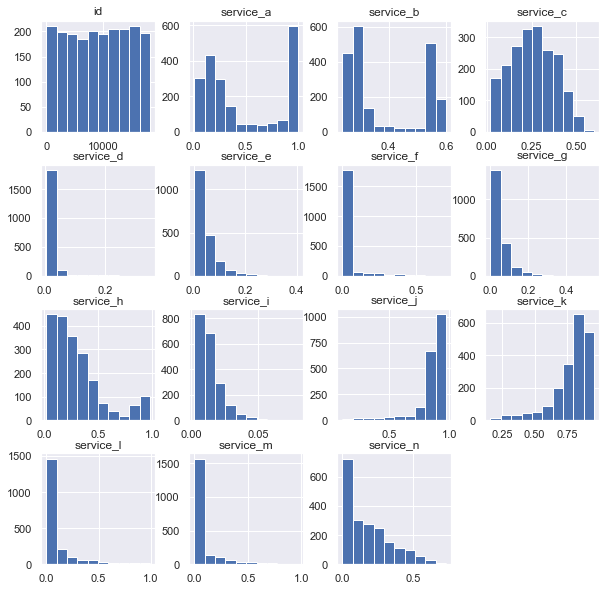

In [415]:
##Посмотрим на итоговое распределение вероятностей
results_proba.hist(figsize=(10,10))
plt.show()

In [321]:
results_proba.to_csv('problem_test_labels', index=False)

In [425]:
t=pd.read_csv('C:/Users/danil/problem_test_labels.csv')

In [426]:
t

,id,service_a,service_b,service_c,service_d,service_e,service_f,service_g,service_h,service_i,service_j,service_k,service_l,service_m,service_n
0,7957,0.990029,0.523233,0.177265,0.004413,0.038545,0.000763,0.007721,0.041867,0.002502,0.903715,0.876236,0.001076,0.000598,0.071929
1,693,0.032193,0.045904,0.033408,0.029817,0.059859,0.000300,0.008853,0.044510,0.002975,0.925548,0.870593,0.006297,0.002679,0.040297
2,15558,0.408600,0.606104,0.365534,0.005123,0.031174,0.000640,0.080661,0.192192,0.009943,0.817613,0.754604,0.003866,0.002486,0.220461
3,15614,0.281188,0.235097,0.304112,0.004863,0.019739,0.000745,0.108933,0.453033,0.017703,0.833581,0.725728,0.242417,0.200014,0.213523
4,8149,0.949841,0.614540,0.433542,0.001954,0.013710,0.000690,0.129630,0.186452,0.014187,0.696876,0.564802,0.022869,0.001811,0.011374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,200,0.104832,0.122458,0.110740,0.005643,0.101266,0.125039,0.077932,0.178186,0.006862,0.916689,0.793921,0.055763,0.018885,0.015421
1996,10876,0.911218,0.535751,0.427764,0.005307,0.007206,0.120541,0.077046,0.218115,0.010453,0.831681,0.812220,0.007662,0.000448,0.126243
1997,4035,0.264790,0.192035,0.334090,0.005542,0.017815,0.000812,0.047596,0.241552,0.017869,0.913382,0.763582,0.007854,0.000452,0.292266
1998,3640,0.173144,0.177271,0.247949,0.003344,0.018785,0.000313,0.039070,0.260167,0.015651,0.931502,0.811456,0.033393,0.000897,0.011623


In [424]:
t.to_csv('problem_test_labels.csv', index=False)